In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 3
2023-07-27 13:43:46.573041


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-10.6790)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(5.9352)
penalty_target_min tensor(-11.4430) penalty_target_max tensor(6.3885)
train_loss:  -7.829929013729095
valid_loss:  -7.903380934143067
h_min_tilde -11.442984 ell_tilde -7.844619397811889 kappa_tilde 0.0005271660573418457


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.1920928955078125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.612159490585327

 2 3.4412097930908203

 3 3.536489963531494

 4 3.432378053665161

 5 3.2428998947143555

 6 3.3551058769226074

 7 3.147183656692505

 8 3.3026669025421143

 9 3.3068695068359375

 10 3.179022789001465

 11 3.1746327877044678

 12 3.350144624710083

 13 3.41420841217041

 14 3.2427303791046143

 15 3.3365557193756104

 16 3.371840238571167

 17 5.304104566574097

 18 6.768374681472778

 19 6.569169521331787

 20 6.85865044593811

 21 6.822019815444946

 22 6.076285123825073

 23 3.17191743850708

 24 3.2914879322052

 25 3.2497053146362305

 26 3.360687255859375

 27 3.2719037532806396

 28 3.2716193199157715

 29 3.2880914211273193

 30 3.274686098098755

 31 3.322543144226074

 32 3.2429256439208984

 33 3.2199532985687256

 34 3.4023706912994385

 35 3.275439739227295

 36 3.2298316955566406

 37 3.4250755310058594

 38 3.25736403465271

 39 3.2400479316711426

 40 3.4072623252868652

 41 3.458071708679199

 42 3.556811571121216

 43 3.4636430740356445

 44 3

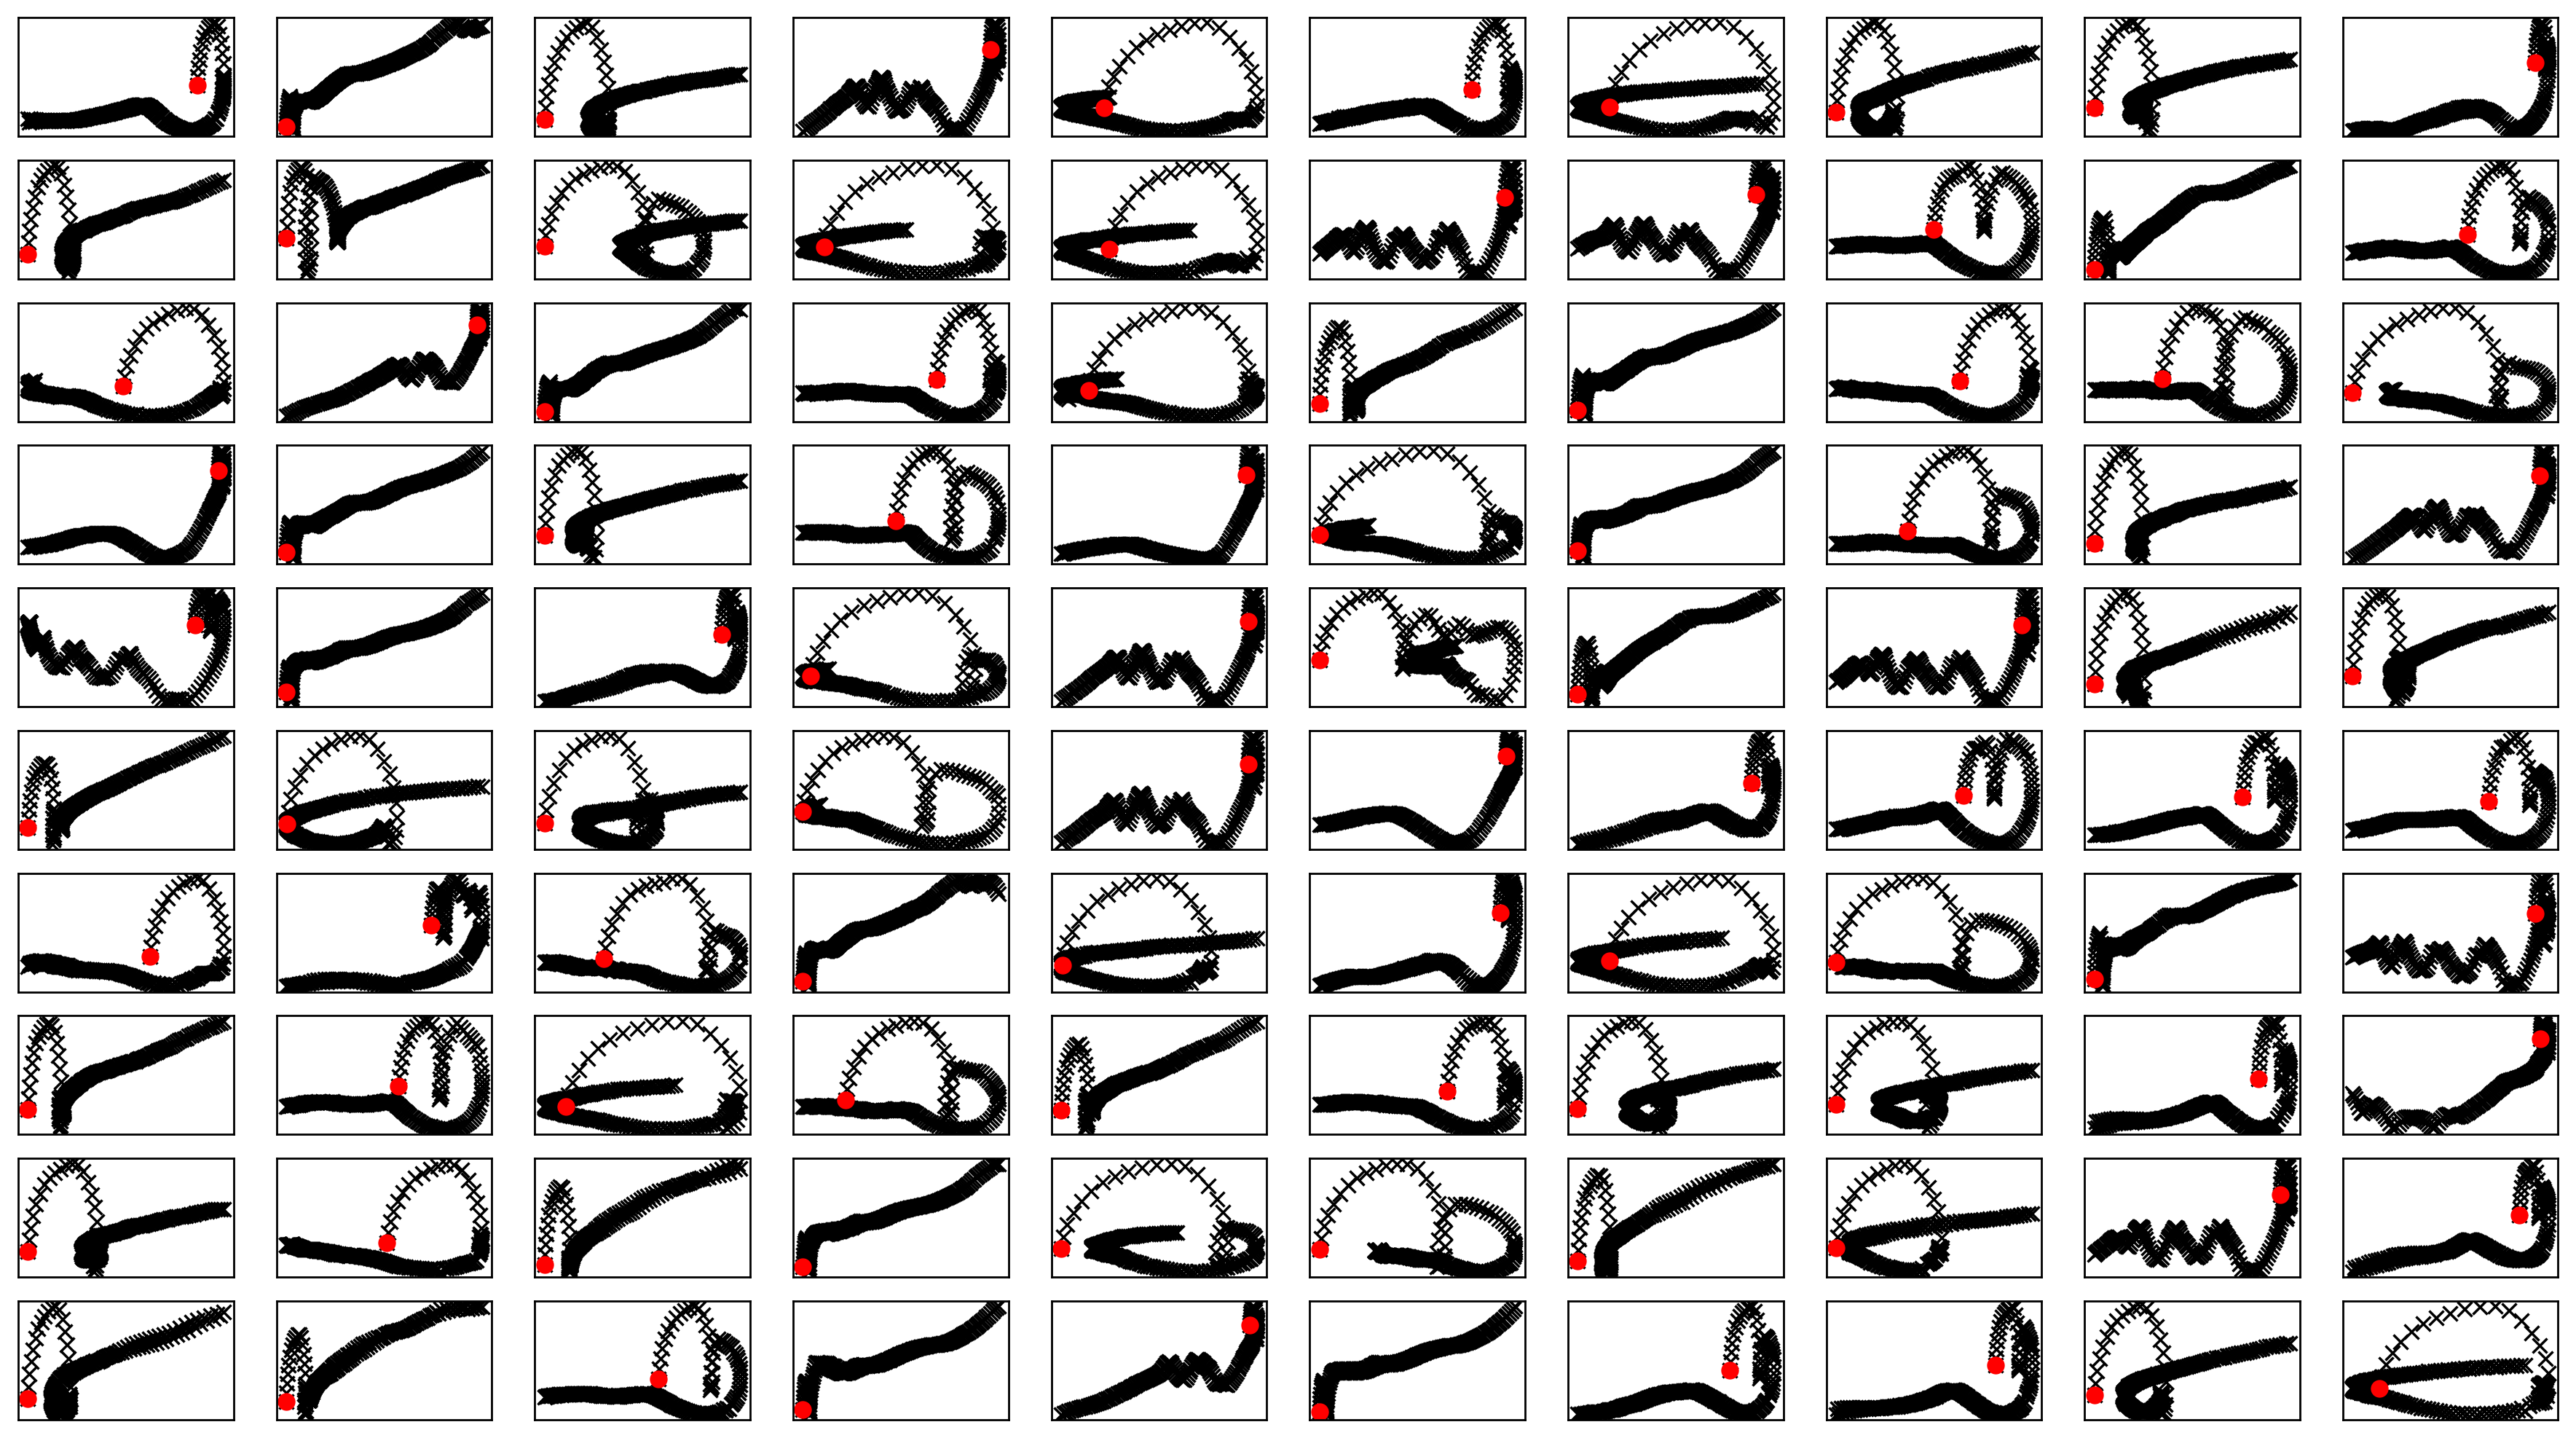

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

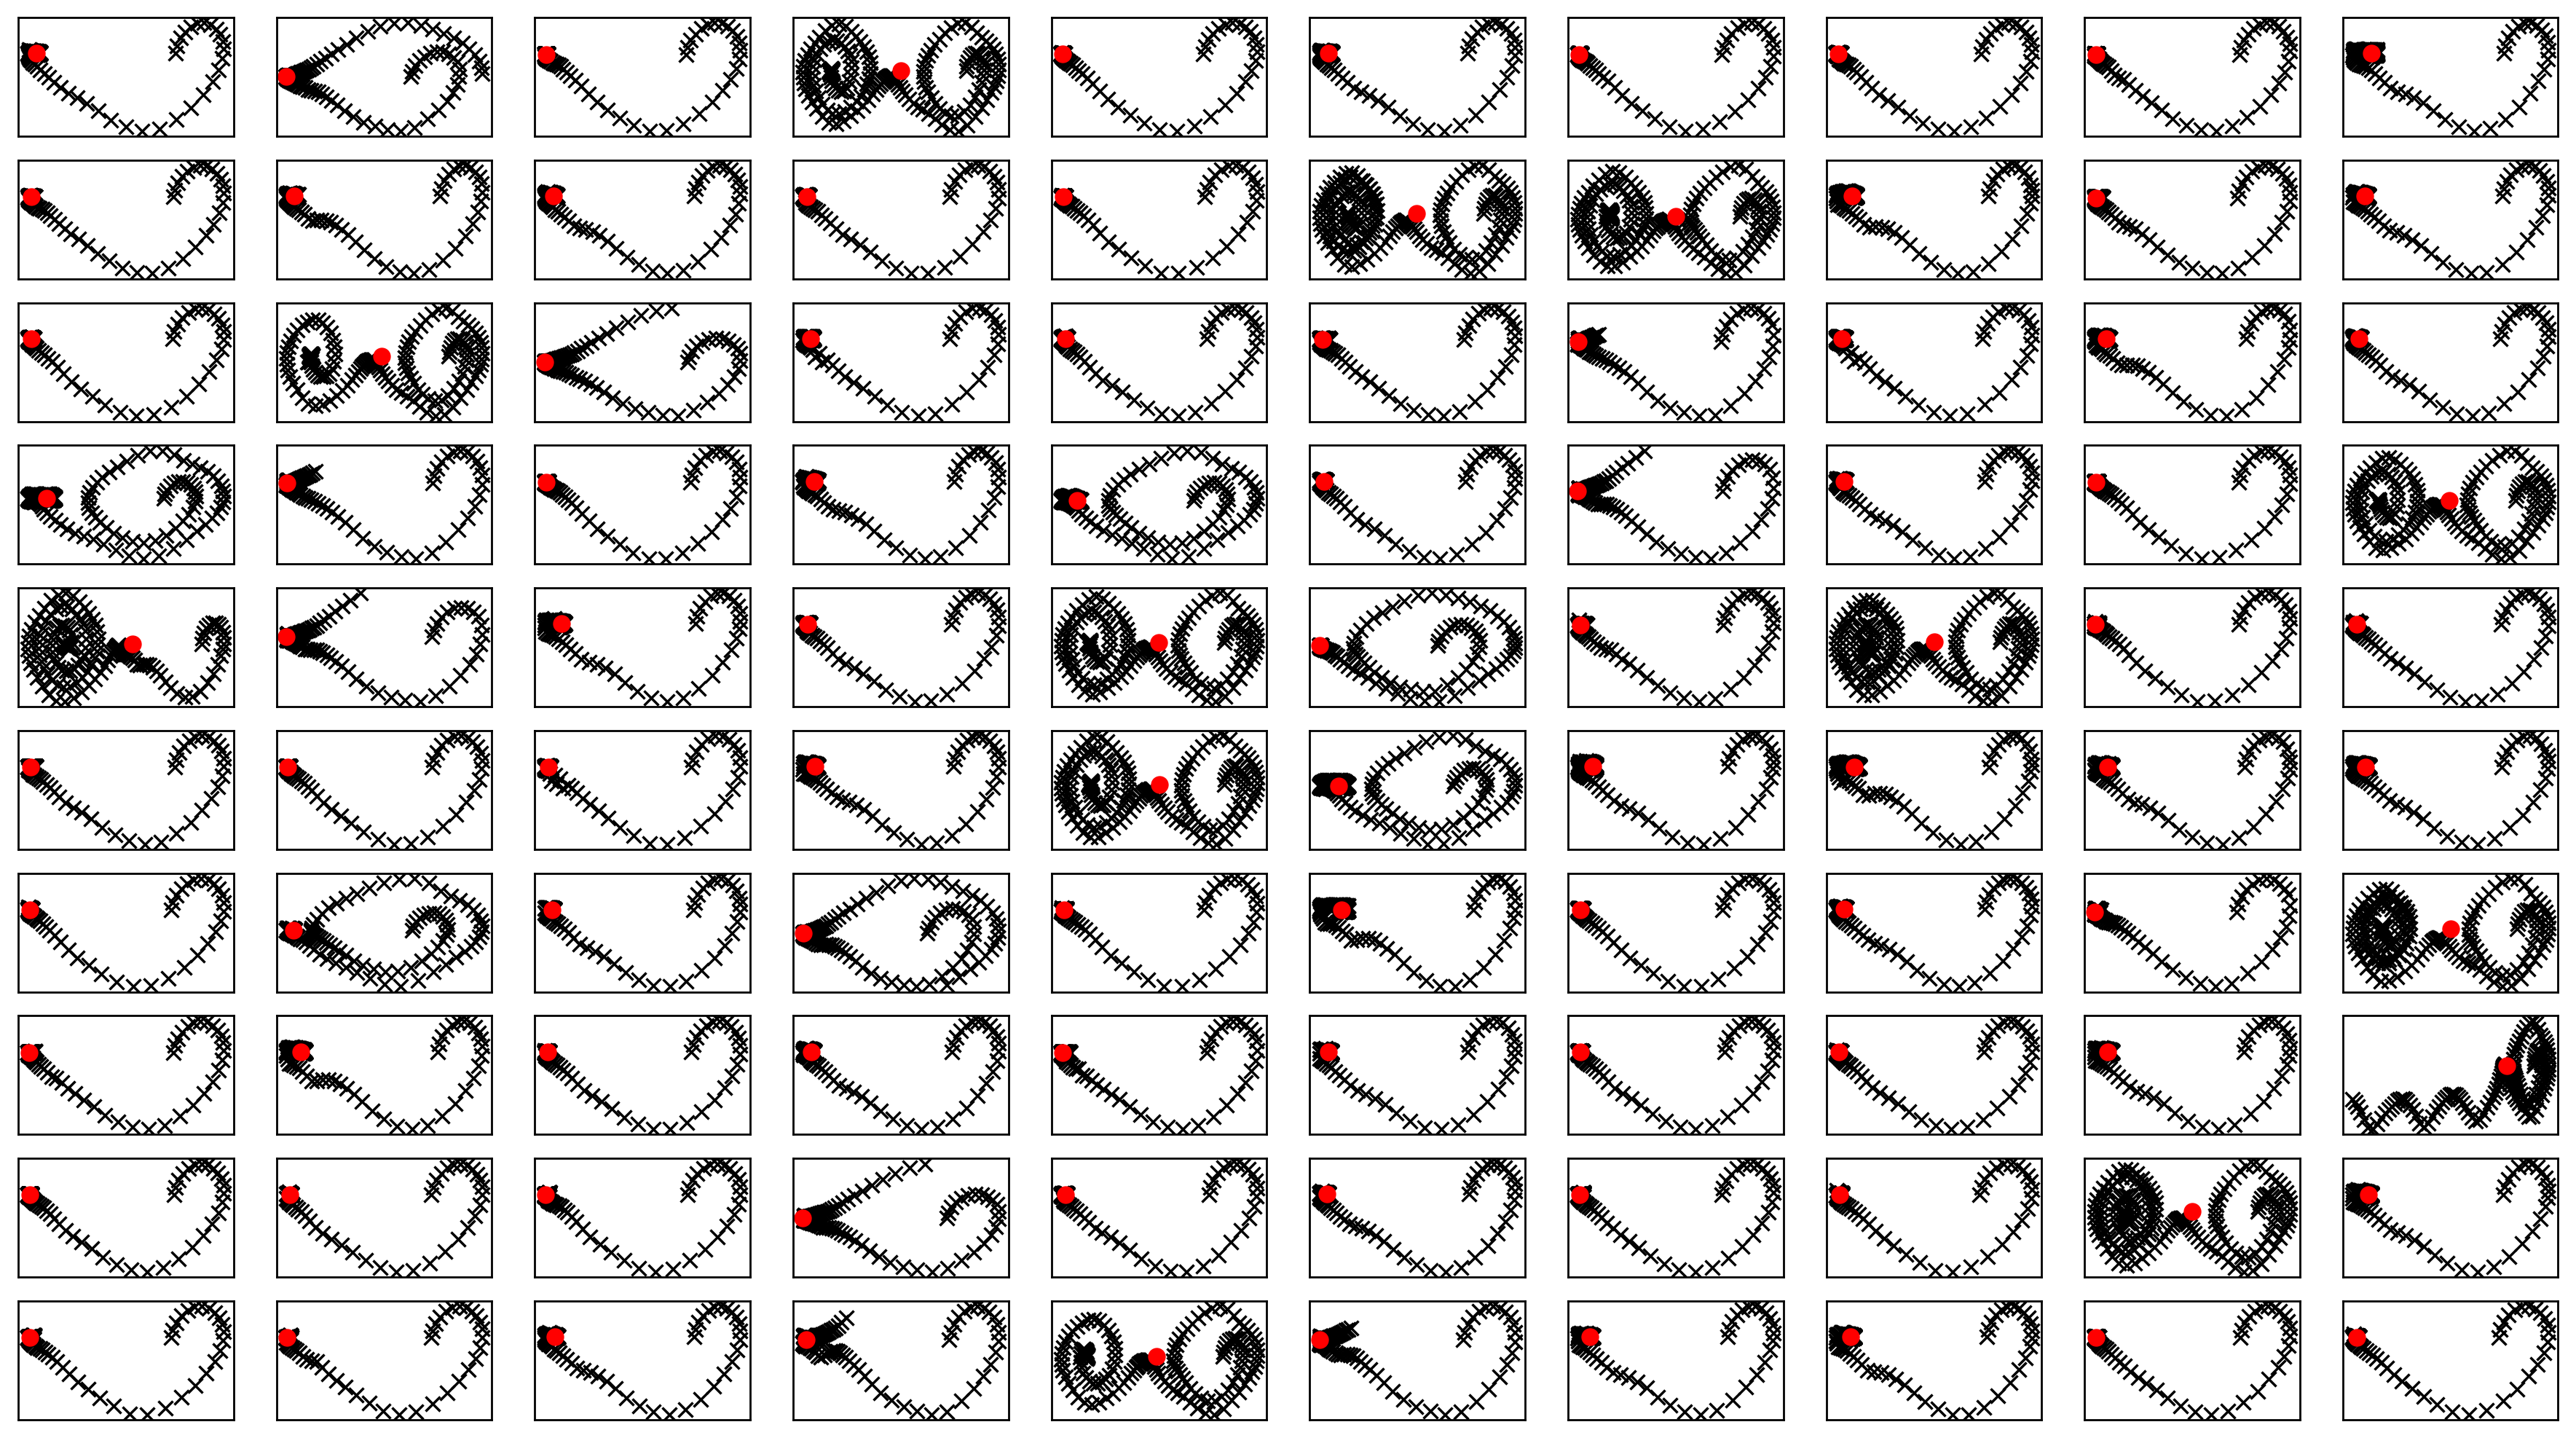

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-27 13:50:54.346234


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.36961  validloss 1.44756±0.00000  bestvalidloss 1.44756  last_update 0
train: iter 1  trainloss 1.21402  validloss 1.28898±0.00000  bestvalidloss 1.28898  last_update 0
train: iter 2  trainloss 1.08584  validloss 1.10775±0.00000  bestvalidloss 1.10775  last_update 0
train: iter 3  trainloss 1.00615  validloss 1.01715±0.00000  bestvalidloss 1.01715  last_update 0
train: iter 4  trainloss 0.94770  validloss 0.95471±0.00000  bestvalidloss 0.95471  last_update 0
train: iter 5  trainloss 0.91463  validloss 0.91423±0.00000  bestvalidloss 0.91423  last_update 0
train: iter 6  trainloss 0.88515  validloss 0.89118±0.00000  bestvalidloss 0.89118  last_update 0
train: iter 7  trainloss 0.85695  validloss 0.86038±0.00000  bestvalidloss 0.86038  last_update 0
train: iter 8  trainloss 0.83975  validloss 0.83147±0.00000  bestvalidloss 0.83147  last_update 0
train: iter 9  trainloss 0.81229  validloss 0.80693±0.00000  bestvalidloss 0.80693  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.41074  validloss 0.38584±0.00000  bestvalidloss 0.37765  last_update 1
train: iter 84  trainloss 0.41101  validloss 0.40022±0.00000  bestvalidloss 0.37765  last_update 2
train: iter 85  trainloss 0.40979  validloss 0.37792±0.00000  bestvalidloss 0.37765  last_update 3
train: iter 86  trainloss 0.40452  validloss 0.37774±0.00000  bestvalidloss 0.37765  last_update 4
train: iter 87  trainloss 0.40481  validloss 0.38669±0.00000  bestvalidloss 0.37765  last_update 5
train: iter 88  trainloss 0.40930  validloss 0.37352±0.00000  bestvalidloss 0.37352  last_update 0
train: iter 89  trainloss 0.39983  validloss 0.38348±0.00000  bestvalidloss 0.37352  last_update 1
train: iter 90  trainloss 0.39663  validloss 0.37714±0.00000  bestvalidloss 0.37352  last_update 2
train: iter 91  trainloss 0.39961  validloss 0.38701±0.00000  bestvalidloss 0.37352  last_update 3
train: iter 92  trainloss 0.39924  validloss 0.39764±0.00000  bestvalidloss 0.37352  last_update 4
train: ite

train: iter 167  trainloss 0.35715  validloss 0.33476±0.00000  bestvalidloss 0.33048  last_update 12
train: iter 168  trainloss 0.35190  validloss 0.33991±0.00000  bestvalidloss 0.33048  last_update 13
train: iter 169  trainloss 0.35592  validloss 0.35191±0.00000  bestvalidloss 0.33048  last_update 14
train: iter 170  trainloss 0.36235  validloss 0.38557±0.00000  bestvalidloss 0.33048  last_update 15
train: iter 171  trainloss 0.35489  validloss 0.34294±0.00000  bestvalidloss 0.33048  last_update 16
train: iter 172  trainloss 0.36084  validloss 0.34516±0.00000  bestvalidloss 0.33048  last_update 17
train: iter 173  trainloss 0.36111  validloss 0.33729±0.00000  bestvalidloss 0.33048  last_update 18
train: iter 174  trainloss 0.36248  validloss 0.33256±0.00000  bestvalidloss 0.33048  last_update 19
train: iter 175  trainloss 0.35616  validloss 0.33519±0.00000  bestvalidloss 0.33048  last_update 20
train: iter 176  trainloss 0.35261  validloss 0.33692±0.00000  bestvalidloss 0.33048  last_

train: iter 249  trainloss 0.32931  validloss 0.31767±0.00000  bestvalidloss 0.30923  last_update 5
train: iter 250  trainloss 0.33115  validloss 0.31133±0.00000  bestvalidloss 0.30923  last_update 6
train: iter 251  trainloss 0.32642  validloss 0.31662±0.00000  bestvalidloss 0.30923  last_update 7
train: iter 252  trainloss 0.32958  validloss 0.32431±0.00000  bestvalidloss 0.30923  last_update 8
train: iter 253  trainloss 0.33431  validloss 0.31765±0.00000  bestvalidloss 0.30923  last_update 9
train: iter 254  trainloss 0.33608  validloss 0.32759±0.00000  bestvalidloss 0.30923  last_update 10
train: iter 255  trainloss 0.32942  validloss 0.32509±0.00000  bestvalidloss 0.30923  last_update 11
train: iter 256  trainloss 0.33011  validloss 0.31055±0.00000  bestvalidloss 0.30923  last_update 12
train: iter 257  trainloss 0.33184  validloss 0.31050±0.00000  bestvalidloss 0.30923  last_update 13
train: iter 258  trainloss 0.33280  validloss 0.31150±0.00000  bestvalidloss 0.30923  last_updat

train: iter 331  trainloss 0.31541  validloss 0.30108±0.00000  bestvalidloss 0.29317  last_update 9
train: iter 332  trainloss 0.31153  validloss 0.30288±0.00000  bestvalidloss 0.29317  last_update 10
train: iter 333  trainloss 0.30991  validloss 0.30617±0.00000  bestvalidloss 0.29317  last_update 11
train: iter 334  trainloss 0.31291  validloss 0.30952±0.00000  bestvalidloss 0.29317  last_update 12
train: iter 335  trainloss 0.31302  validloss 0.29958±0.00000  bestvalidloss 0.29317  last_update 13
train: iter 336  trainloss 0.31100  validloss 0.29639±0.00000  bestvalidloss 0.29317  last_update 14
train: iter 337  trainloss 0.31201  validloss 0.29263±0.00000  bestvalidloss 0.29263  last_update 0
train: iter 338  trainloss 0.31002  validloss 0.29768±0.00000  bestvalidloss 0.29263  last_update 1
train: iter 339  trainloss 0.30895  validloss 0.29258±0.00000  bestvalidloss 0.29258  last_update 0
train: iter 340  trainloss 0.31642  validloss 0.32825±0.00000  bestvalidloss 0.29258  last_upda

train: iter 414  trainloss 0.30086  validloss 0.29705±0.00000  bestvalidloss 0.28414  last_update 22
train: iter 415  trainloss 0.29426  validloss 0.29633±0.00000  bestvalidloss 0.28414  last_update 23
train: iter 416  trainloss 0.30183  validloss 0.29418±0.00000  bestvalidloss 0.28414  last_update 24
train: iter 417  trainloss 0.29819  validloss 0.31262±0.00000  bestvalidloss 0.28414  last_update 25
train: iter 418  trainloss 0.30135  validloss 0.30834±0.00000  bestvalidloss 0.28414  last_update 26
train: iter 419  trainloss 0.29517  validloss 0.29426±0.00000  bestvalidloss 0.28414  last_update 27
train: iter 420  trainloss 0.29562  validloss 0.28538±0.00000  bestvalidloss 0.28414  last_update 28
train: iter 421  trainloss 0.29757  validloss 0.29430±0.00000  bestvalidloss 0.28414  last_update 29
train: iter 422  trainloss 0.29520  validloss 0.34799±0.00000  bestvalidloss 0.28414  last_update 30
train: iter 423  trainloss 0.29343  validloss 0.29319±0.00000  bestvalidloss 0.28414  last_

train: iter 496  trainloss 0.28509  validloss 0.29750±0.00000  bestvalidloss 0.27928  last_update 43
train: iter 497  trainloss 0.28368  validloss 0.28329±0.00000  bestvalidloss 0.27928  last_update 44
train: iter 498  trainloss 0.28165  validloss 0.28778±0.00000  bestvalidloss 0.27928  last_update 45
train: iter 499  trainloss 0.27954  validloss 0.29519±0.00000  bestvalidloss 0.27928  last_update 46
train: iter 500  trainloss 0.28101  validloss 0.28693±0.00000  bestvalidloss 0.27928  last_update 47
train: iter 501  trainloss 0.28533  validloss 0.28977±0.00000  bestvalidloss 0.27928  last_update 48
train: iter 502  trainloss 0.28792  validloss 0.29772±0.00000  bestvalidloss 0.27928  last_update 49
train: iter 503  trainloss 0.28548  validloss 0.28612±0.00000  bestvalidloss 0.27928  last_update 50
train: iter 504  trainloss 0.28570  validloss 0.28268±0.00000  bestvalidloss 0.27928  last_update 51
train: iter 505  trainloss 0.28513  validloss 0.27735±0.00000  bestvalidloss 0.27735  last_

train: iter 578  trainloss 0.27555  validloss 0.28152±0.00000  bestvalidloss 0.27312  last_update 26
train: iter 579  trainloss 0.27881  validloss 0.28695±0.00000  bestvalidloss 0.27312  last_update 27
train: iter 580  trainloss 0.27309  validloss 0.27729±0.00000  bestvalidloss 0.27312  last_update 28
train: iter 581  trainloss 0.27307  validloss 0.27670±0.00000  bestvalidloss 0.27312  last_update 29
train: iter 582  trainloss 0.27746  validloss 0.29637±0.00000  bestvalidloss 0.27312  last_update 30
train: iter 583  trainloss 0.27349  validloss 0.27980±0.00000  bestvalidloss 0.27312  last_update 31
train: iter 584  trainloss 0.27771  validloss 0.28842±0.00000  bestvalidloss 0.27312  last_update 32
train: iter 585  trainloss 0.27144  validloss 0.27597±0.00000  bestvalidloss 0.27312  last_update 33
train: iter 586  trainloss 0.27461  validloss 0.28037±0.00000  bestvalidloss 0.27312  last_update 34
train: iter 587  trainloss 0.27179  validloss 0.27515±0.00000  bestvalidloss 0.27312  last_

train: iter 661  trainloss 0.26521  validloss 0.28483±0.00000  bestvalidloss 0.26827  last_update 6
train: iter 662  trainloss 0.26743  validloss 0.27730±0.00000  bestvalidloss 0.26827  last_update 7
train: iter 663  trainloss 0.25790  validloss 0.27586±0.00000  bestvalidloss 0.26827  last_update 8
train: iter 664  trainloss 0.26482  validloss 0.28297±0.00000  bestvalidloss 0.26827  last_update 9
train: iter 665  trainloss 0.26726  validloss 0.29107±0.00000  bestvalidloss 0.26827  last_update 10
train: iter 666  trainloss 0.26904  validloss 0.27321±0.00000  bestvalidloss 0.26827  last_update 11
train: iter 667  trainloss 0.26440  validloss 0.27737±0.00000  bestvalidloss 0.26827  last_update 12
train: iter 668  trainloss 0.26529  validloss 0.27817±0.00000  bestvalidloss 0.26827  last_update 13
train: iter 669  trainloss 0.26538  validloss 0.28028±0.00000  bestvalidloss 0.26827  last_update 14
train: iter 670  trainloss 0.26602  validloss 0.27793±0.00000  bestvalidloss 0.26827  last_upda

train: iter 744  trainloss 0.26214  validloss 0.28717±0.00000  bestvalidloss 0.26827  last_update 89
train: iter 745  trainloss 0.25841  validloss 0.28616±0.00000  bestvalidloss 0.26827  last_update 90
train: iter 746  trainloss 0.25959  validloss 0.28068±0.00000  bestvalidloss 0.26827  last_update 91
train: iter 747  trainloss 0.26377  validloss 0.28174±0.00000  bestvalidloss 0.26827  last_update 92
train: iter 748  trainloss 0.25840  validloss 0.27538±0.00000  bestvalidloss 0.26827  last_update 93
train: iter 749  trainloss 0.25909  validloss 0.27086±0.00000  bestvalidloss 0.26827  last_update 94
train: iter 750  trainloss 0.26163  validloss 0.28354±0.00000  bestvalidloss 0.26827  last_update 95
train: iter 751  trainloss 0.25592  validloss 0.27153±0.00000  bestvalidloss 0.26827  last_update 96
train: iter 752  trainloss 0.26242  validloss 0.29289±0.00000  bestvalidloss 0.26827  last_update 97
train: iter 753  trainloss 0.25832  validloss 0.27456±0.00000  bestvalidloss 0.26827  last_

train_loss:  -4.4728415653914215
valid_loss:  -5.34019070777893
weight_alpha 1.0 h_min_tilde -11.442984 ell_tilde -4.646311393868923 kappa_tilde 0.0003835763627173665
train_loss:  -3.8522335242748262
valid_loss:  -3.9758519260406495
weight_alpha 0.1 h_min_tilde -11.442984 ell_tilde -3.876957204627991 kappa_tilde 0.000363551610761663


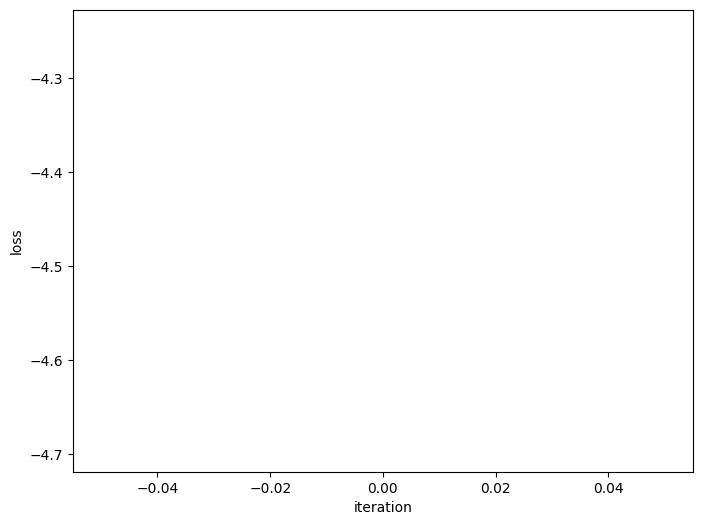

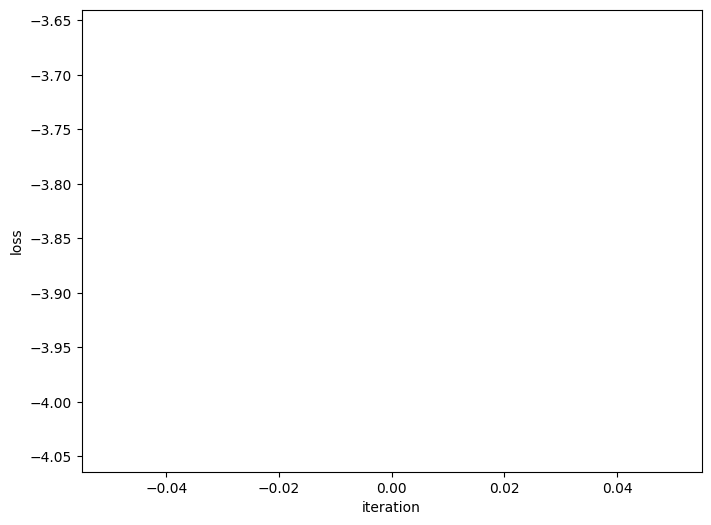

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -752.09656  validloss -798.48424±0.00000  bestvalidloss -798.48424  last_update 0
train: iter 1  trainloss -764.70328  validloss -793.59875±0.00000  bestvalidloss -798.48424  last_update 1
train: iter 2  trainloss -747.05188  validloss -763.04673±0.00000  bestvalidloss -798.48424  last_update 2
train: iter 3  trainloss -760.03542  validloss -779.19281±0.00000  bestvalidloss -798.48424  last_update 3
train: iter 4  trainloss -766.66726  validloss -794.49117±0.00000  bestvalidloss -798.48424  last_update 4
train: iter 5  trainloss -761.44437  validloss -777.96926±0.00000  bestvalidloss -798.48424  last_update 5
train: iter 6  trainloss -780.50402  validloss -793.47241±0.00000  bestvalidloss -798.48424  last_update 6
train: iter 7  trainloss -759.45927  validloss -812.85296±0.00000  bestvalidloss -812.85296  last_update 0
train: iter 8  trainloss -764.93824  validloss -806.42109±0.00000  bestvalidloss -812.85296  last_u

train: iter 76  trainloss -837.60482  validloss -836.73088±0.00000  bestvalidloss -866.37947  last_update 9
train: iter 77  trainloss -833.81549  validloss -854.55278±0.00000  bestvalidloss -866.37947  last_update 10
train: iter 78  trainloss -843.46055  validloss -847.20067±0.00000  bestvalidloss -866.37947  last_update 11
train: iter 79  trainloss -813.94508  validloss -799.51969±0.00000  bestvalidloss -866.37947  last_update 12
train: iter 80  trainloss -820.85755  validloss -739.90985±0.00000  bestvalidloss -866.37947  last_update 13
train: iter 81  trainloss -807.56997  validloss -831.41904±0.00000  bestvalidloss -866.37947  last_update 14
train: iter 82  trainloss -809.32823  validloss -824.30022±0.00000  bestvalidloss -866.37947  last_update 15
train: iter 83  trainloss -836.79352  validloss -799.01772±0.00000  bestvalidloss -866.37947  last_update 16
train: iter 84  trainloss -837.39664  validloss -882.35950±0.00000  bestvalidloss -882.35950  last_update 0
train: iter 85  train

train: iter 151  trainloss -876.65983  validloss -857.34899±0.00000  bestvalidloss -898.30837  last_update 5
train: iter 152  trainloss -891.17122  validloss -857.28421±0.00000  bestvalidloss -898.30837  last_update 6
train: iter 153  trainloss -887.93896  validloss -850.02675±0.00000  bestvalidloss -898.30837  last_update 7
train: iter 154  trainloss -889.61697  validloss -835.17014±0.00000  bestvalidloss -898.30837  last_update 8
train: iter 155  trainloss -856.25963  validloss -874.42990±0.00000  bestvalidloss -898.30837  last_update 9
train: iter 156  trainloss -865.37866  validloss -765.58966±0.00000  bestvalidloss -898.30837  last_update 10
train: iter 157  trainloss -887.73873  validloss -846.58473±0.00000  bestvalidloss -898.30837  last_update 11
train: iter 158  trainloss -881.80055  validloss -854.77748±0.00000  bestvalidloss -898.30837  last_update 12
train: iter 159  trainloss -891.25015  validloss -896.43703±0.00000  bestvalidloss -898.30837  last_update 13
train: iter 160

train: iter 226  trainloss -904.64634  validloss -849.79155±0.00000  bestvalidloss -944.19627  last_update 50
train: iter 227  trainloss -898.85802  validloss -827.05097±0.00000  bestvalidloss -944.19627  last_update 51
train: iter 228  trainloss -927.57977  validloss -871.81648±0.00000  bestvalidloss -944.19627  last_update 52
train: iter 229  trainloss -873.59498  validloss -863.88291±0.00000  bestvalidloss -944.19627  last_update 53
train: iter 230  trainloss -921.23231  validloss -851.65884±0.00000  bestvalidloss -944.19627  last_update 54
train: iter 231  trainloss -937.43627  validloss -882.50034±0.00000  bestvalidloss -944.19627  last_update 55
train: iter 232  trainloss -928.70046  validloss -849.40878±0.00000  bestvalidloss -944.19627  last_update 56
train: iter 233  trainloss -921.60456  validloss -871.08342±0.00000  bestvalidloss -944.19627  last_update 57
train: iter 234  trainloss -928.46207  validloss -883.46880±0.00000  bestvalidloss -944.19627  last_update 58
train: ite

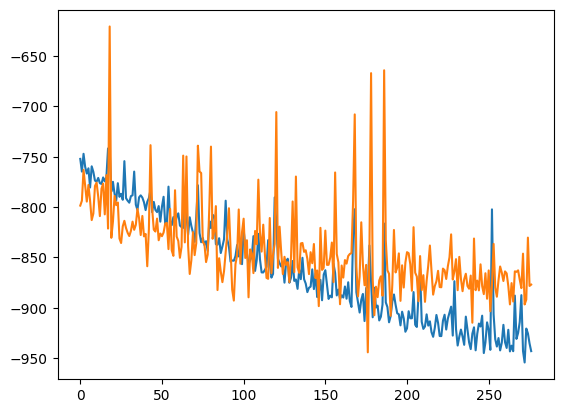

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-27 14:15:45.477742


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2
predict diverge [-15.2394825  -17.86887644  -8.45705316 -14.26663545] [-0.63822614 -3.37148586 -1.10183737  9.3625348 ] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 68
predict diverge [-35.13073797  22.21936926 -19.97518343 -15.41162175] [ 0.36293343 13.86447936 -0.72668287 -0.16898611] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 128
predict diverge [  6.0668744   24.91939091 -15.64027195 -16.42451273] [ 0.75776714  7.94400224 -0.69678689 -0.88836872] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 85

 3
predict diverge [-40.29212669 -73.98346053  -7.90887991 -24.56621624] [ -0.48810578 -63.35993152  -1.06717228  -1.92545367] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 178

 4

 5

 6

 7

 8

 9

 10

 11
predict diverge [-39.47630349 -25.01094197 -19.6


 73

 74

 75
predict diverge [ -4.01429359 119.8037534  -30.20306825 -21.43776361] [  0.415566   109.29308974  -0.93199644  -0.12769704] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 124

 76

 77
predict diverge [-28.90714578 -18.66702395  -8.11130283  -9.49969011] [-0.79702432 -1.55374411 -0.70793204  7.32344743] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 110

 78
predict diverge [-10.98363647 -17.78058556  -9.51378031 -26.58521819] [-0.50286646 -6.41992321 -0.94772979 -5.39989185] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 133
predict diverge [-30.19364461 -17.0756426  -13.72001644 -30.91949873] [ -0.71181171  -0.65615789  -0.86015333 -12.52164567] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 93

 79
predict diverge [ -2.43550178 -84.96117234 -13.2722686  -1

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.87240  validloss 1.91488±0.00000  bestvalidloss 1.91488  last_update 0
train: iter 1  trainloss 0.84741  validloss 0.88083±0.00000  bestvalidloss 0.88083  last_update 0
train: iter 2  trainloss 0.70425  validloss 0.54141±0.00000  bestvalidloss 0.54141  last_update 0
train: iter 3  trainloss 0.66016  validloss 0.51234±0.00000  bestvalidloss 0.51234  last_update 0
train: iter 4  trainloss 0.62983  validloss 0.48734±0.00000  bestvalidloss 0.48734  last_update 0
train: iter 5  trainloss 0.60764  validloss 0.49097±0.00000  bestvalidloss 0.48734  last_update 1
train: iter 6  trainloss 0.59407  validloss 0.46841±0.00000  bestvalidloss 0.46841  last_update 0
train: iter 7  trainloss 0.57279  validloss 0.45755±0.00000  bestvalidloss 0.45755  last_update 0
train: iter 8  trainloss 0.55760  validloss 0.45982±0.00000  bestvalidloss 0.45755  last_update 1
train: iter 9  trainloss 0.55023  validloss 0.45907±0.00000  bestvalidloss 0.45755  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.42570  validloss 0.40728±0.00000  bestvalidloss 0.38993  last_update 1
train: iter 84  trainloss 0.41957  validloss 0.39390±0.00000  bestvalidloss 0.38993  last_update 2
train: iter 85  trainloss 0.42055  validloss 0.39285±0.00000  bestvalidloss 0.38993  last_update 3
train: iter 86  trainloss 0.41962  validloss 0.38650±0.00000  bestvalidloss 0.38650  last_update 0
train: iter 87  trainloss 0.41637  validloss 0.41643±0.00000  bestvalidloss 0.38650  last_update 1
train: iter 88  trainloss 0.42069  validloss 0.41073±0.00000  bestvalidloss 0.38650  last_update 2
train: iter 89  trainloss 0.42154  validloss 0.38634±0.00000  bestvalidloss 0.38634  last_update 0
train: iter 90  trainloss 0.41888  validloss 0.40756±0.00000  bestvalidloss 0.38634  last_update 1
train: iter 91  trainloss 0.41768  validloss 0.39034±0.00000  bestvalidloss 0.38634  last_update 2
train: iter 92  trainloss 0.42046  validloss 0.41220±0.00000  bestvalidloss 0.38634  last_update 3
train: ite

train: iter 166  trainloss 0.39252  validloss 0.38510±0.00000  bestvalidloss 0.37579  last_update 58
train: iter 167  trainloss 0.39363  validloss 0.38940±0.00000  bestvalidloss 0.37579  last_update 59
train: iter 168  trainloss 0.39167  validloss 0.38697±0.00000  bestvalidloss 0.37579  last_update 60
train: iter 169  trainloss 0.39704  validloss 0.39652±0.00000  bestvalidloss 0.37579  last_update 61
train: iter 170  trainloss 0.39087  validloss 0.41935±0.00000  bestvalidloss 0.37579  last_update 62
train: iter 171  trainloss 0.39511  validloss 0.39779±0.00000  bestvalidloss 0.37579  last_update 63
train: iter 172  trainloss 0.39469  validloss 0.39294±0.00000  bestvalidloss 0.37579  last_update 64
train: iter 173  trainloss 0.38752  validloss 0.38396±0.00000  bestvalidloss 0.37579  last_update 65
train: iter 174  trainloss 0.39405  validloss 0.38004±0.00000  bestvalidloss 0.37579  last_update 66
train: iter 175  trainloss 0.39336  validloss 0.38862±0.00000  bestvalidloss 0.37579  last_

train_loss:  -5.645511336040498
valid_loss:  -5.212173587226868
weight_alpha 1.0 h_min_tilde -11.519584 ell_tilde -5.558843786277772 kappa_tilde 0.00040959053634107885
train_loss:  -4.9083148183345795
valid_loss:  -4.693561703491211
weight_alpha 0.1 h_min_tilde -11.519584 ell_tilde -4.865364195365906 kappa_tilde 0.00038766039902428737


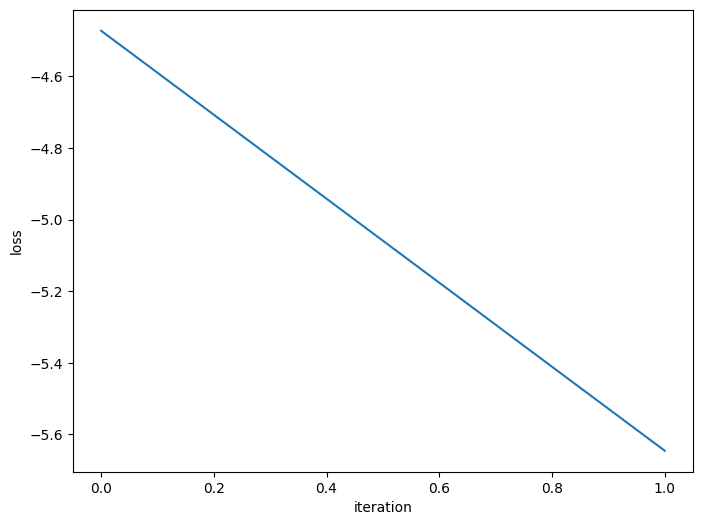

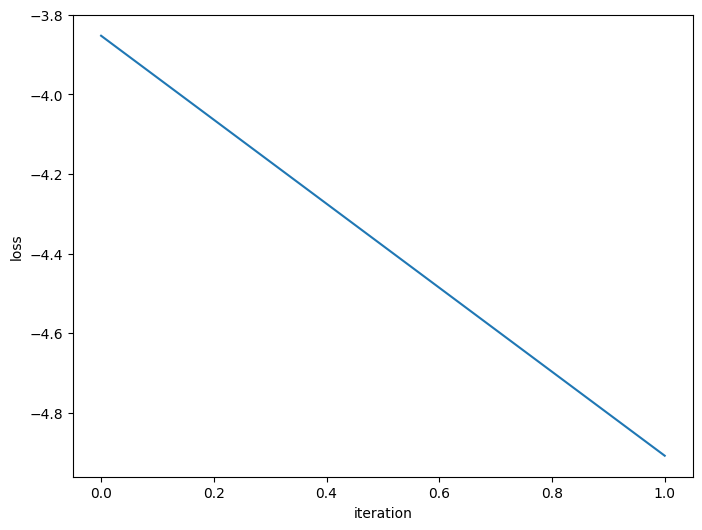

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -911.12775  validloss -943.28384±0.00000  bestvalidloss -943.28384  last_update 0
train: iter 1  trainloss -975.78114  validloss -931.69451±0.00000  bestvalidloss -943.28384  last_update 1
train: iter 2  trainloss -951.11687  validloss -928.28934±0.00000  bestvalidloss -943.28384  last_update 2
train: iter 3  trainloss -896.97597  validloss -953.65311±0.00000  bestvalidloss -953.65311  last_update 0
train: iter 4  trainloss -945.76597  validloss -859.64352±0.00000  bestvalidloss -953.65311  last_update 1
train: iter 5  trainloss -972.26630  validloss -932.33589±0.00000  bestvalidloss -953.65311  last_update 2
train: iter 6  trainloss -925.41343  validloss -921.80886±0.00000  bestvalidloss -953.65311  last_update 3
train: iter 7  trainloss -971.70161  validloss -921.92361±0.00000  bestvalidloss -953.65311  last_update 4
train: iter 8  trainloss -898.32044  validloss -537.66254±0.00000  bestvalidloss -953.65311  last_u

train: iter 76  trainloss -954.85571  validloss -888.84081±0.00000  bestvalidloss -972.59518  last_update 18
train: iter 77  trainloss -994.93748  validloss -917.46426±0.00000  bestvalidloss -972.59518  last_update 19
train: iter 78  trainloss -998.72536  validloss -948.88171±0.00000  bestvalidloss -972.59518  last_update 20
train: iter 79  trainloss -944.44615  validloss -954.29269±0.00000  bestvalidloss -972.59518  last_update 21
train: iter 80  trainloss -983.26493  validloss -906.40810±0.00000  bestvalidloss -972.59518  last_update 22
train: iter 81  trainloss -987.27067  validloss -919.86593±0.00000  bestvalidloss -972.59518  last_update 23
train: iter 82  trainloss -923.91954  validloss -842.29509±0.00000  bestvalidloss -972.59518  last_update 24
train: iter 83  trainloss -972.32724  validloss -917.41025±0.00000  bestvalidloss -972.59518  last_update 25
train: iter 84  trainloss -974.76863  validloss -915.43499±0.00000  bestvalidloss -972.59518  last_update 26
train: iter 85  tra

train: iter 151  trainloss -985.29303  validloss -900.11014±0.00000  bestvalidloss -972.59518  last_update 93
train: iter 152  trainloss -1003.65937  validloss -922.09708±0.00000  bestvalidloss -972.59518  last_update 94
train: iter 153  trainloss -1016.95562  validloss -964.00530±0.00000  bestvalidloss -972.59518  last_update 95
train: iter 154  trainloss -969.78151  validloss -926.25011±0.00000  bestvalidloss -972.59518  last_update 96
train: iter 155  trainloss -1000.61771  validloss -868.86096±0.00000  bestvalidloss -972.59518  last_update 97
train: iter 156  trainloss -1007.94680  validloss -975.01674±0.00000  bestvalidloss -975.01674  last_update 0
train: iter 157  trainloss -996.49932  validloss -917.05312±0.00000  bestvalidloss -975.01674  last_update 1
train: iter 158  trainloss -1005.52159  validloss -978.97347±0.00000  bestvalidloss -978.97347  last_update 0
train: iter 159  trainloss -1006.40375  validloss -949.34637±0.00000  bestvalidloss -978.97347  last_update 1
train: i

train: iter 225  trainloss -1027.54935  validloss -906.17725±0.00000  bestvalidloss -1034.07820  last_update 42
train: iter 226  trainloss -1060.33362  validloss -975.51348±0.00000  bestvalidloss -1034.07820  last_update 43
train: iter 227  trainloss -1031.03936  validloss -1009.21787±0.00000  bestvalidloss -1034.07820  last_update 44
train: iter 228  trainloss -1065.50199  validloss -982.29977±0.00000  bestvalidloss -1034.07820  last_update 45
train: iter 229  trainloss -1052.48403  validloss -977.16797±0.00000  bestvalidloss -1034.07820  last_update 46
train: iter 230  trainloss -934.44990  validloss -962.84047±0.00000  bestvalidloss -1034.07820  last_update 47
train: iter 231  trainloss -1048.24303  validloss -967.45011±0.00000  bestvalidloss -1034.07820  last_update 48
train: iter 232  trainloss -1053.51458  validloss -987.13589±0.00000  bestvalidloss -1034.07820  last_update 49
train: iter 233  trainloss -1043.57406  validloss -959.66230±0.00000  bestvalidloss -1034.07820  last_up

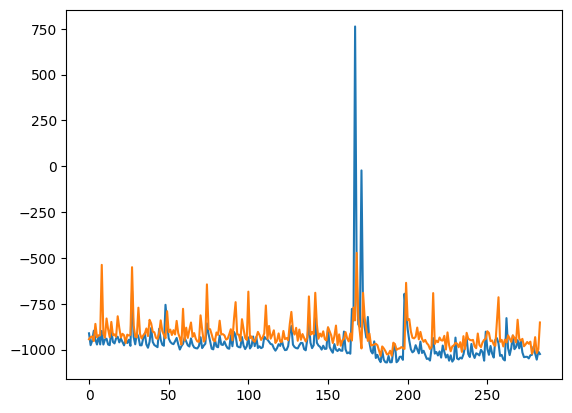

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-27 14:38:47.954171


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15
predict diverge [ -1.96473766 -85.58362305 -25.78433356 -24.44659569] [  0.23904061 -91.24752275  -1.26448978   2.58480853] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 100

 16

 17
predict diverge [-29.87627613  36.78589402 -21.4045542  -25.2954415 ] [ 0.55282156 24.45606966 -1.37442161  2.53878581] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 141

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28
predict diverge [ -1.39310644 -28.47054568 -38.9060334  -21.50254645] [  0.0526788  -27.04960631  -1.16128043   0.85024314] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 92
predict diverge [-29.87756097 -21.81823214 -11.05257301 -22.82689381] [ -0.27725454 -15.87708218  -1.08018376  -2.50859263] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.51326  validloss 0.46290±0.00000  bestvalidloss 0.46290  last_update 0
train: iter 1  trainloss 0.46159  validloss 0.39264±0.00000  bestvalidloss 0.39264  last_update 0
train: iter 2  trainloss 0.44330  validloss 0.36866±0.00000  bestvalidloss 0.36866  last_update 0
train: iter 3  trainloss 0.43945  validloss 0.36593±0.00000  bestvalidloss 0.36593  last_update 0
train: iter 4  trainloss 0.43570  validloss 0.36073±0.00000  bestvalidloss 0.36073  last_update 0
train: iter 5  trainloss 0.43548  validloss 0.36237±0.00000  bestvalidloss 0.36073  last_update 1
train: iter 6  trainloss 0.42957  validloss 0.36412±0.00000  bestvalidloss 0.36073  last_update 2
train: iter 7  trainloss 0.42451  validloss 0.36509±0.00000  bestvalidloss 0.36073  last_update 3
train: iter 8  trainloss 0.41943  validloss 0.37698±0.00000  bestvalidloss 0.36073  last_update 4
train: iter 9  trainloss 0.42479  validloss 0.36044±0.00000  bestvalidloss 0.36044  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.37042  validloss 0.33753±0.00000  bestvalidloss 0.32942  last_update 16
train: iter 84  trainloss 0.37692  validloss 0.33365±0.00000  bestvalidloss 0.32942  last_update 17
train: iter 85  trainloss 0.36966  validloss 0.35616±0.00000  bestvalidloss 0.32942  last_update 18
train: iter 86  trainloss 0.37411  validloss 0.33652±0.00000  bestvalidloss 0.32942  last_update 19
train: iter 87  trainloss 0.37034  validloss 0.32968±0.00000  bestvalidloss 0.32942  last_update 20
train: iter 88  trainloss 0.37656  validloss 0.35190±0.00000  bestvalidloss 0.32942  last_update 21
train: iter 89  trainloss 0.37048  validloss 0.33296±0.00000  bestvalidloss 0.32942  last_update 22
train: iter 90  trainloss 0.37172  validloss 0.32935±0.00000  bestvalidloss 0.32935  last_update 0
train: iter 91  trainloss 0.36821  validloss 0.33130±0.00000  bestvalidloss 0.32935  last_update 1
train: iter 92  trainloss 0.37075  validloss 0.34087±0.00000  bestvalidloss 0.32935  last_update 2
tra

train: iter 165  trainloss 0.35295  validloss 0.33954±0.00000  bestvalidloss 0.32796  last_update 53
train: iter 166  trainloss 0.35378  validloss 0.34235±0.00000  bestvalidloss 0.32796  last_update 54
train: iter 167  trainloss 0.35306  validloss 0.34700±0.00000  bestvalidloss 0.32796  last_update 55
train: iter 168  trainloss 0.35777  validloss 0.33934±0.00000  bestvalidloss 0.32796  last_update 56
train: iter 169  trainloss 0.35367  validloss 0.33878±0.00000  bestvalidloss 0.32796  last_update 57
train: iter 170  trainloss 0.34766  validloss 0.34267±0.00000  bestvalidloss 0.32796  last_update 58
train: iter 171  trainloss 0.35997  validloss 0.37777±0.00000  bestvalidloss 0.32796  last_update 59
train: iter 172  trainloss 0.35729  validloss 0.35268±0.00000  bestvalidloss 0.32796  last_update 60
train: iter 173  trainloss 0.35436  validloss 0.34734±0.00000  bestvalidloss 0.32796  last_update 61
train: iter 174  trainloss 0.35273  validloss 0.33539±0.00000  bestvalidloss 0.32796  last_

train_loss:  -4.407402255332469
valid_loss:  -3.6781006445884707
weight_alpha 1.0 h_min_tilde -11.475012 ell_tilde -4.26154193318367 kappa_tilde 0.0003723298781994373
train_loss:  -4.573803607177735
valid_loss:  -4.182914810562133
weight_alpha 0.1 h_min_tilde -11.475012 ell_tilde -4.4956258478546145 kappa_tilde 0.00037852223149351084


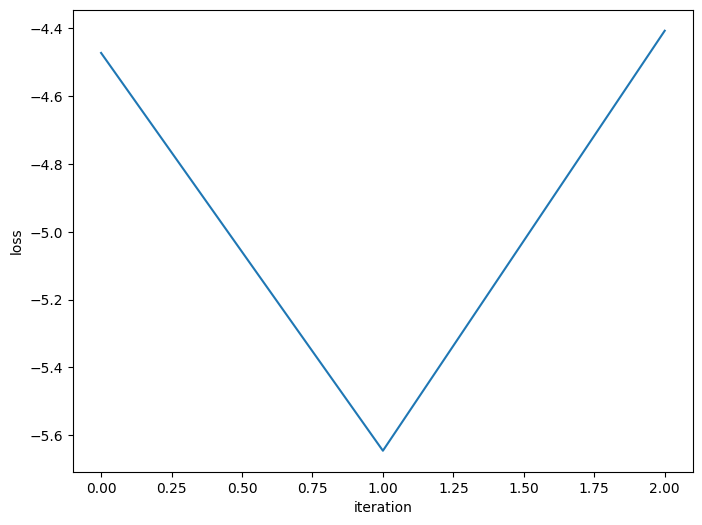

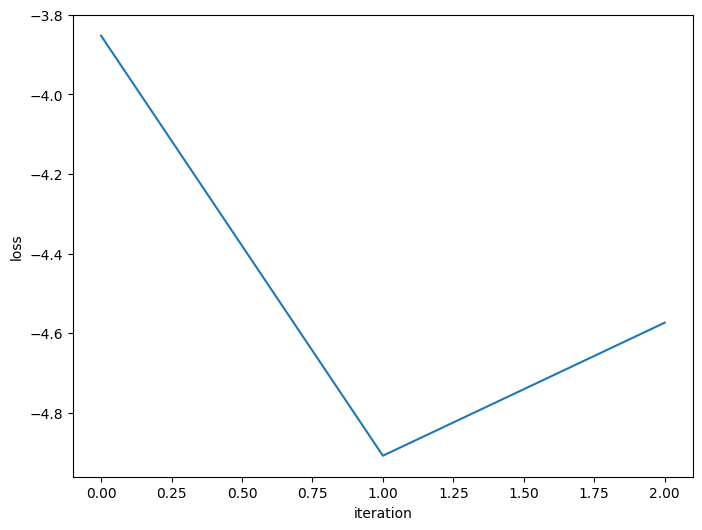

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -904.12566  validloss -838.35165±0.00000  bestvalidloss -838.35165  last_update 0
train: iter 1  trainloss -899.86052  validloss -894.62385±0.00000  bestvalidloss -894.62385  last_update 0
train: iter 2  trainloss -862.54709  validloss -725.42270±0.00000  bestvalidloss -894.62385  last_update 1
train: iter 3  trainloss -926.76487  validloss -814.16731±0.00000  bestvalidloss -894.62385  last_update 2
train: iter 4  trainloss -931.05564  validloss -883.21780±0.00000  bestvalidloss -894.62385  last_update 3
train: iter 5  trainloss -912.54887  validloss -851.02066±0.00000  bestvalidloss -894.62385  last_update 4
train: iter 6  trainloss -926.03583  validloss -826.88752±0.00000  bestvalidloss -894.62385  last_update 5
train: iter 7  trainloss -943.12940  validloss -883.51248±0.00000  bestvalidloss -894.62385  last_update 6
train: iter 8  trainloss -893.96226  validloss -829.97193±0.00000  bestvalidloss -894.62385  last_u

train: iter 76  trainloss -918.57426  validloss -867.71843±0.00000  bestvalidloss -900.79659  last_update 14
train: iter 77  trainloss -926.61507  validloss -889.24593±0.00000  bestvalidloss -900.79659  last_update 15
train: iter 78  trainloss -936.01258  validloss -872.86935±0.00000  bestvalidloss -900.79659  last_update 16
train: iter 79  trainloss -928.71837  validloss -847.60820±0.00000  bestvalidloss -900.79659  last_update 17
train: iter 80  trainloss -934.83533  validloss -875.36186±0.00000  bestvalidloss -900.79659  last_update 18
train: iter 81  trainloss -940.95238  validloss -865.37647±0.00000  bestvalidloss -900.79659  last_update 19
train: iter 82  trainloss -932.23958  validloss -805.84410±0.00000  bestvalidloss -900.79659  last_update 20
train: iter 83  trainloss -930.30845  validloss -839.59837±0.00000  bestvalidloss -900.79659  last_update 21
train: iter 84  trainloss -935.93482  validloss -890.69532±0.00000  bestvalidloss -900.79659  last_update 22
train: iter 85  tra

train: iter 151  trainloss -950.46391  validloss -873.31596±0.00000  bestvalidloss -916.73617  last_update 2
train: iter 152  trainloss -951.13932  validloss -894.37312±0.00000  bestvalidloss -916.73617  last_update 3
train: iter 153  trainloss -897.29422  validloss -841.19230±0.00000  bestvalidloss -916.73617  last_update 4
train: iter 154  trainloss -945.63651  validloss -805.81987±0.00000  bestvalidloss -916.73617  last_update 5
train: iter 155  trainloss -964.50967  validloss -885.96496±0.00000  bestvalidloss -916.73617  last_update 6
train: iter 156  trainloss -951.92159  validloss -870.16192±0.00000  bestvalidloss -916.73617  last_update 7
train: iter 157  trainloss -946.36151  validloss -892.04185±0.00000  bestvalidloss -916.73617  last_update 8
train: iter 158  trainloss -896.13430  validloss -829.07867±0.00000  bestvalidloss -916.73617  last_update 9
train: iter 159  trainloss -860.07341  validloss -654.61492±0.00000  bestvalidloss -916.73617  last_update 10
train: iter 160  t

train: iter 226  trainloss -974.34198  validloss -902.02073±0.00000  bestvalidloss -939.65225  last_update 20
train: iter 227  trainloss -728.80921  validloss -921.14443±0.00000  bestvalidloss -939.65225  last_update 21
train: iter 228  trainloss -860.36789  validloss -758.67685±0.00000  bestvalidloss -939.65225  last_update 22
train: iter 229  trainloss -909.13520  validloss -843.95123±0.00000  bestvalidloss -939.65225  last_update 23
train: iter 230  trainloss -909.03721  validloss -857.85761±0.00000  bestvalidloss -939.65225  last_update 24
train: iter 231  trainloss -904.97118  validloss -856.38268±0.00000  bestvalidloss -939.65225  last_update 25
train: iter 232  trainloss -911.48652  validloss -843.29998±0.00000  bestvalidloss -939.65225  last_update 26
train: iter 233  trainloss -896.85800  validloss -843.41340±0.00000  bestvalidloss -939.65225  last_update 27
train: iter 234  trainloss -920.89759  validloss -855.81077±0.00000  bestvalidloss -939.65225  last_update 28
train: ite

train: iter 301  trainloss -949.04612  validloss -851.45360±0.00000  bestvalidloss -939.65225  last_update 95
train: iter 302  trainloss -973.80960  validloss -871.75885±0.00000  bestvalidloss -939.65225  last_update 96
train: iter 303  trainloss -988.72645  validloss -904.45344±0.00000  bestvalidloss -939.65225  last_update 97
train: iter 304  trainloss -990.84398  validloss -910.85945±0.00000  bestvalidloss -939.65225  last_update 98
train: iter 305  trainloss -949.09284  validloss -808.78899±0.00000  bestvalidloss -939.65225  last_update 99
train: iter 306  trainloss -953.51776  validloss -828.66162±0.00000  bestvalidloss -939.65225  last_update 100
train: fin
penalty_target_min tensor(-11.4406) penalty_target_max tensor(15.5638)


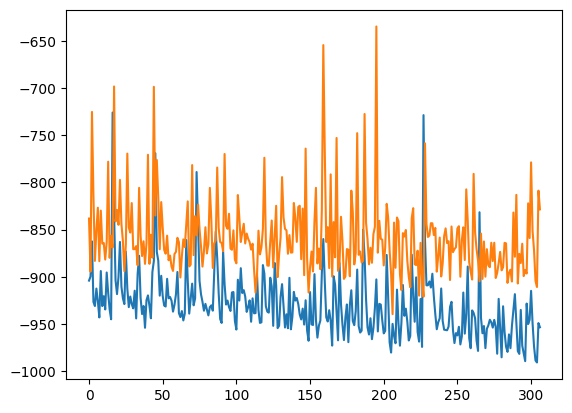

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-27 15:04:39.762772


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3
predict diverge [ -9.71223796 -17.71466859 -36.19342202 -20.23951162] [-0.91608229 -4.65589092 -1.21860505 -2.70627206] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 114
predict diverge [-18.48347523 -18.9072297  -18.08934414 -18.63873959] [-0.66377723 -7.66217511 -0.96615057  1.98676908] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 98
predict diverge [-65.95681929 -18.16280241 -32.09432022 -15.26487244] [-0.90965247 -4.32487892 -0.85655646  4.19339665] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 173

 4
predict diverge [ -3.85529668  18.61840148 -46.02973375 -23.793414  ] [ 0.35511655  2.58308888 -1.47851231 -2.43821181] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 113
predict diverge [ -6.48246643 -59.15383914 -29.73655448 -29.55691531] [ -0.190609


 55
predict diverge [-15.15367753 -18.72219399 -39.98404944 -17.44673335] [ -0.29640973 -20.32399378  -1.32471438   3.875554  ] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 114

 56

 57
predict diverge [-14.82492093 -25.83283483 -20.73815336 -15.3221954 ] [ -0.73960005 -12.42984797  -0.90646094   1.81117571] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 65
predict diverge [ -3.60385818  24.53243238 -15.01745138 -28.22404052] [-0.10710477 24.95515861 -1.204581   -5.87781898] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 47

 58

 59

 60

 61
predict diverge [ -1.66526085  13.13107432 -29.53688716 -32.47105187] [ -0.40457053  15.2122205   -1.11185563 -10.79880314] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 130
predict diverge [ -8.98541569  19.68291849 -15.8899374 

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.57662  validloss 0.70994±0.00000  bestvalidloss 0.70994  last_update 0
train: iter 1  trainloss 0.50858  validloss 0.50739±0.00000  bestvalidloss 0.50739  last_update 0
train: iter 2  trainloss 0.49316  validloss 0.51409±0.00000  bestvalidloss 0.50739  last_update 1
train: iter 3  trainloss 0.47840  validloss 0.49686±0.00000  bestvalidloss 0.49686  last_update 0
train: iter 4  trainloss 0.47802  validloss 0.49515±0.00000  bestvalidloss 0.49515  last_update 0
train: iter 5  trainloss 0.46421  validloss 0.48892±0.00000  bestvalidloss 0.48892  last_update 0
train: iter 6  trainloss 0.46510  validloss 0.48188±0.00000  bestvalidloss 0.48188  last_update 0
train: iter 7  trainloss 0.45610  validloss 0.47632±0.00000  bestvalidloss 0.47632  last_update 0
train: iter 8  trainloss 0.46190  validloss 0.47963±0.00000  bestvalidloss 0.47632  last_update 1
train: iter 9  trainloss 0.45204  validloss 0.51508±0.00000  bestvalidloss 0.47632  last_update 2
train: iter 10  trai

train: iter 84  trainloss 0.40416  validloss 0.47770±0.00000  bestvalidloss 0.47271  last_update 66
train: iter 85  trainloss 0.40413  validloss 0.51223±0.00000  bestvalidloss 0.47271  last_update 67
train: iter 86  trainloss 0.40265  validloss 0.48452±0.00000  bestvalidloss 0.47271  last_update 68
train: iter 87  trainloss 0.40886  validloss 0.49339±0.00000  bestvalidloss 0.47271  last_update 69
train: iter 88  trainloss 0.40320  validloss 0.49168±0.00000  bestvalidloss 0.47271  last_update 70
train: iter 89  trainloss 0.40518  validloss 0.47798±0.00000  bestvalidloss 0.47271  last_update 71
train: iter 90  trainloss 0.40488  validloss 0.47239±0.00000  bestvalidloss 0.47239  last_update 0
train: iter 91  trainloss 0.40178  validloss 0.49282±0.00000  bestvalidloss 0.47239  last_update 1
train: iter 92  trainloss 0.41138  validloss 0.48894±0.00000  bestvalidloss 0.47239  last_update 2
train: iter 93  trainloss 0.40860  validloss 0.48325±0.00000  bestvalidloss 0.47239  last_update 3
trai

train: iter 166  trainloss 0.40115  validloss 0.47467±0.00000  bestvalidloss 0.47057  last_update 15
train: iter 167  trainloss 0.39177  validloss 0.49348±0.00000  bestvalidloss 0.47057  last_update 16
train: iter 168  trainloss 0.38922  validloss 0.48403±0.00000  bestvalidloss 0.47057  last_update 17
train: iter 169  trainloss 0.39479  validloss 0.49488±0.00000  bestvalidloss 0.47057  last_update 18
train: iter 170  trainloss 0.39153  validloss 0.48505±0.00000  bestvalidloss 0.47057  last_update 19
train: iter 171  trainloss 0.38928  validloss 0.47402±0.00000  bestvalidloss 0.47057  last_update 20
train: iter 172  trainloss 0.38960  validloss 0.48375±0.00000  bestvalidloss 0.47057  last_update 21
train: iter 173  trainloss 0.38606  validloss 0.48613±0.00000  bestvalidloss 0.47057  last_update 22
train: iter 174  trainloss 0.38685  validloss 0.47277±0.00000  bestvalidloss 0.47057  last_update 23
train: iter 175  trainloss 0.39584  validloss 0.52066±0.00000  bestvalidloss 0.47057  last_

train: iter 248  trainloss 0.37007  validloss 0.47410±0.00000  bestvalidloss 0.46186  last_update 1
train: iter 249  trainloss 0.38387  validloss 0.48482±0.00000  bestvalidloss 0.46186  last_update 2
train: iter 250  trainloss 0.37232  validloss 0.47176±0.00000  bestvalidloss 0.46186  last_update 3
train: iter 251  trainloss 0.38109  validloss 0.50070±0.00000  bestvalidloss 0.46186  last_update 4
train: iter 252  trainloss 0.37848  validloss 0.49417±0.00000  bestvalidloss 0.46186  last_update 5
train: iter 253  trainloss 0.38007  validloss 0.47277±0.00000  bestvalidloss 0.46186  last_update 6
train: iter 254  trainloss 0.37834  validloss 0.49825±0.00000  bestvalidloss 0.46186  last_update 7
train: iter 255  trainloss 0.37372  validloss 0.48217±0.00000  bestvalidloss 0.46186  last_update 8
train: iter 256  trainloss 0.37487  validloss 0.47868±0.00000  bestvalidloss 0.46186  last_update 9
train: iter 257  trainloss 0.37973  validloss 0.47489±0.00000  bestvalidloss 0.46186  last_update 10

train: iter 330  trainloss 0.37078  validloss 0.50151±0.00000  bestvalidloss 0.46104  last_update 8
train: iter 331  trainloss 0.37106  validloss 0.49344±0.00000  bestvalidloss 0.46104  last_update 9
train: iter 332  trainloss 0.37563  validloss 0.47230±0.00000  bestvalidloss 0.46104  last_update 10
train: iter 333  trainloss 0.36769  validloss 0.49231±0.00000  bestvalidloss 0.46104  last_update 11
train: iter 334  trainloss 0.36288  validloss 0.48527±0.00000  bestvalidloss 0.46104  last_update 12
train: iter 335  trainloss 0.36084  validloss 0.47355±0.00000  bestvalidloss 0.46104  last_update 13
train: iter 336  trainloss 0.37535  validloss 0.48305±0.00000  bestvalidloss 0.46104  last_update 14
train: iter 337  trainloss 0.36644  validloss 0.47575±0.00000  bestvalidloss 0.46104  last_update 15
train: iter 338  trainloss 0.36466  validloss 0.47353±0.00000  bestvalidloss 0.46104  last_update 16
train: iter 339  trainloss 0.37010  validloss 0.48019±0.00000  bestvalidloss 0.46104  last_up

train: iter 413  trainloss 0.35638  validloss 0.47119±0.00000  bestvalidloss 0.45856  last_update 48
train: iter 414  trainloss 0.36321  validloss 0.51073±0.00000  bestvalidloss 0.45856  last_update 49
train: iter 415  trainloss 0.36272  validloss 0.50541±0.00000  bestvalidloss 0.45856  last_update 50
train: iter 416  trainloss 0.35225  validloss 0.50009±0.00000  bestvalidloss 0.45856  last_update 51
train: iter 417  trainloss 0.35514  validloss 0.50009±0.00000  bestvalidloss 0.45856  last_update 52
train: iter 418  trainloss 0.35755  validloss 0.47072±0.00000  bestvalidloss 0.45856  last_update 53
train: iter 419  trainloss 0.36125  validloss 0.47883±0.00000  bestvalidloss 0.45856  last_update 54
train: iter 420  trainloss 0.35999  validloss 0.49025±0.00000  bestvalidloss 0.45856  last_update 55
train: iter 421  trainloss 0.35974  validloss 0.46454±0.00000  bestvalidloss 0.45856  last_update 56
train: iter 422  trainloss 0.35516  validloss 0.49564±0.00000  bestvalidloss 0.45856  last_

train_loss:  -4.58619824886322
valid_loss:  -4.64438261384964
weight_alpha 1.0 h_min_tilde -11.440554 ell_tilde -4.597835121860504 kappa_tilde 0.00038228359510118873
train_loss:  -4.51204392336607
valid_loss:  -4.4478671293735506
weight_alpha 0.1 h_min_tilde -11.440554 ell_tilde -4.499208564567566 kappa_tilde 0.00037955802809328036


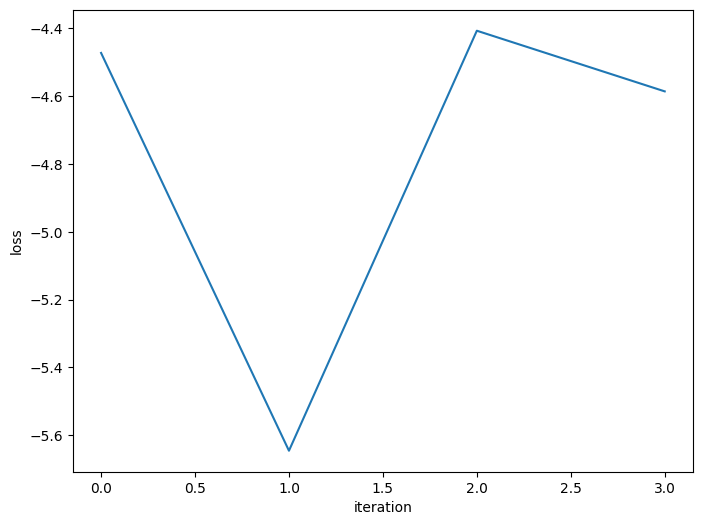

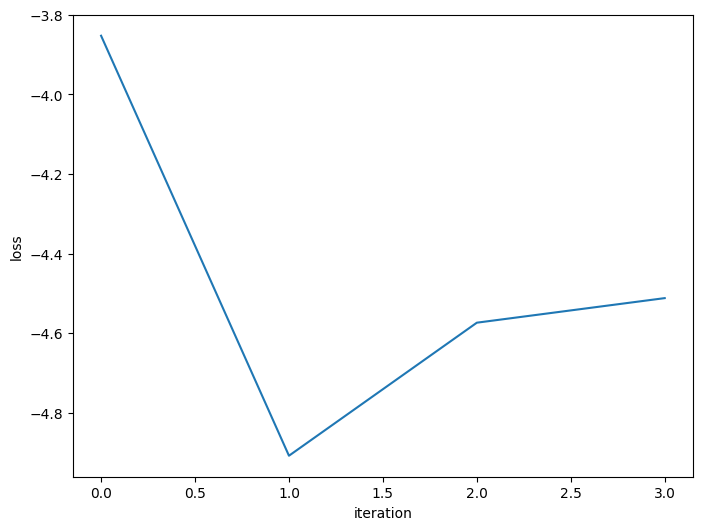

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -898.62385  validloss -896.67500±0.00000  bestvalidloss -896.67500  last_update 0
train: iter 1  trainloss -909.57412  validloss -855.09569±0.00000  bestvalidloss -896.67500  last_update 1
train: iter 2  trainloss -917.85659  validloss -913.11898±0.00000  bestvalidloss -913.11898  last_update 0
train: iter 3  trainloss -930.56722  validloss -898.55612±0.00000  bestvalidloss -913.11898  last_update 1
train: iter 4  trainloss -933.05406  validloss -913.23634±0.00000  bestvalidloss -913.23634  last_update 0
train: iter 5  trainloss -919.21331  validloss -897.78721±0.00000  bestvalidloss -913.23634  last_update 1
train: iter 6  trainloss -915.69905  validloss -908.73092±0.00000  bestvalidloss -913.23634  last_update 2
train: iter 7  trainloss -937.02292  validloss -903.21260±0.00000  bestvalidloss -913.23634  last_update 3
train: iter 8  trainloss -904.58225  validloss -882.42503±0.00000  bestvalidloss -913.23634  last_u

train: iter 76  trainloss -941.75726  validloss -953.81986±0.00000  bestvalidloss -953.81986  last_update 0
train: iter 77  trainloss -923.80647  validloss -894.20818±0.00000  bestvalidloss -953.81986  last_update 1
train: iter 78  trainloss -901.54770  validloss -867.01873±0.00000  bestvalidloss -953.81986  last_update 2
train: iter 79  trainloss -917.17604  validloss -906.31673±0.00000  bestvalidloss -953.81986  last_update 3
train: iter 80  trainloss -927.79671  validloss -886.02693±0.00000  bestvalidloss -953.81986  last_update 4
train: iter 81  trainloss -939.70721  validloss -910.49140±0.00000  bestvalidloss -953.81986  last_update 5
train: iter 82  trainloss -869.70883  validloss -879.27991±0.00000  bestvalidloss -953.81986  last_update 6
train: iter 83  trainloss -932.90413  validloss -882.73794±0.00000  bestvalidloss -953.81986  last_update 7
train: iter 84  trainloss -910.68164  validloss -906.83052±0.00000  bestvalidloss -953.81986  last_update 8
train: iter 85  trainloss -9

train: iter 151  trainloss -937.40491  validloss -870.27463±0.00000  bestvalidloss -953.81986  last_update 75
train: iter 152  trainloss -944.03850  validloss -936.86268±0.00000  bestvalidloss -953.81986  last_update 76
train: iter 153  trainloss -938.64805  validloss -906.08840±0.00000  bestvalidloss -953.81986  last_update 77
train: iter 154  trainloss -913.94929  validloss -893.84482±0.00000  bestvalidloss -953.81986  last_update 78
train: iter 155  trainloss -942.50542  validloss -926.14693±0.00000  bestvalidloss -953.81986  last_update 79
train: iter 156  trainloss -948.78978  validloss -890.20756±0.00000  bestvalidloss -953.81986  last_update 80
train: iter 157  trainloss -950.94157  validloss -875.92015±0.00000  bestvalidloss -953.81986  last_update 81
train: iter 158  trainloss -953.20596  validloss -924.74514±0.00000  bestvalidloss -953.81986  last_update 82
train: iter 159  trainloss -930.18355  validloss -876.29401±0.00000  bestvalidloss -953.81986  last_update 83
train: ite

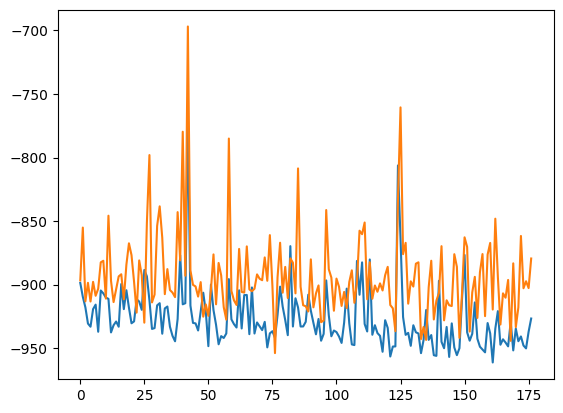

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-27 15:29:30.188905


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37
predict diverge [  1.16538643  33.26343862 -43.95899118 -34.17746891] [-1.94217455e-02  3.48698840e+01 -1.56590855e+00 -1.14161087e+01] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 127

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54
predict diverge [ 31.12600211  24.51849606 -41.11723763 -20.8368505 ] [ 0.5755501  13.29315657 -1.31006997 -1.6838058 ] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 137

 55

 56

 57

 58

 59
predict diverge [  3.25236848 -24.47482802 -46.26331306 -16.07535746] [ -0.1572898  -19.42720552  -1.29746151   5.69748428] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 119

 60

 61

 62


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.60525  validloss 0.72336±0.00000  bestvalidloss 0.72336  last_update 0
train: iter 1  trainloss 0.52990  validloss 0.61563±0.00000  bestvalidloss 0.61563  last_update 0
train: iter 2  trainloss 0.49590  validloss 0.57733±0.00000  bestvalidloss 0.57733  last_update 0
train: iter 3  trainloss 0.48376  validloss 0.58345±0.00000  bestvalidloss 0.57733  last_update 1
train: iter 4  trainloss 0.47244  validloss 0.61954±0.00000  bestvalidloss 0.57733  last_update 2
train: iter 5  trainloss 0.47106  validloss 0.59314±0.00000  bestvalidloss 0.57733  last_update 3
train: iter 6  trainloss 0.45875  validloss 0.61450±0.00000  bestvalidloss 0.57733  last_update 4
train: iter 7  trainloss 0.45344  validloss 0.61110±0.00000  bestvalidloss 0.57733  last_update 5
train: iter 8  trainloss 0.45381  validloss 0.57774±0.00000  bestvalidloss 0.57733  last_update 6
train: iter 9  trainloss 0.44859  validloss 0.59582±0.00000  bestvalidloss 0.57733  last_update 7
train: iter 10  trai

train: iter 84  trainloss 0.39232  validloss 0.65553±0.00000  bestvalidloss 0.54794  last_update 69
train: iter 85  trainloss 0.39445  validloss 0.64500±0.00000  bestvalidloss 0.54794  last_update 70
train: iter 86  trainloss 0.39201  validloss 0.65014±0.00000  bestvalidloss 0.54794  last_update 71
train: iter 87  trainloss 0.39430  validloss 0.64137±0.00000  bestvalidloss 0.54794  last_update 72
train: iter 88  trainloss 0.39469  validloss 0.64319±0.00000  bestvalidloss 0.54794  last_update 73
train: iter 89  trainloss 0.39070  validloss 0.66430±0.00000  bestvalidloss 0.54794  last_update 74
train: iter 90  trainloss 0.38924  validloss 0.67953±0.00000  bestvalidloss 0.54794  last_update 75
train: iter 91  trainloss 0.39048  validloss 0.65619±0.00000  bestvalidloss 0.54794  last_update 76
train: iter 92  trainloss 0.39207  validloss 0.66842±0.00000  bestvalidloss 0.54794  last_update 77
train: iter 93  trainloss 0.38808  validloss 0.65120±0.00000  bestvalidloss 0.54794  last_update 78


train_loss:  -5.558534581431747
valid_loss:  -6.133917054224015
weight_alpha 1.0 h_min_tilde -11.549082 ell_tilde -5.673611075990201 kappa_tilde 0.00041255197125200107
train_loss:  -4.731721893787384
valid_loss:  -4.552816239929199
weight_alpha 0.1 h_min_tilde -11.549082 ell_tilde -4.695940763015747 kappa_tilde 0.0003819927893761126


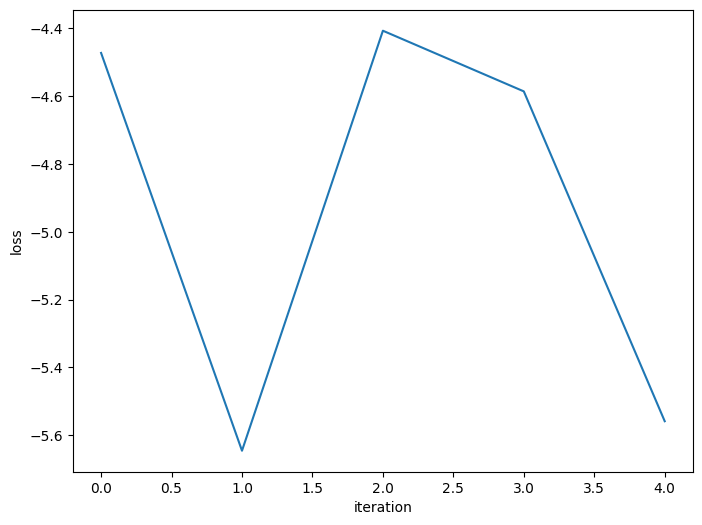

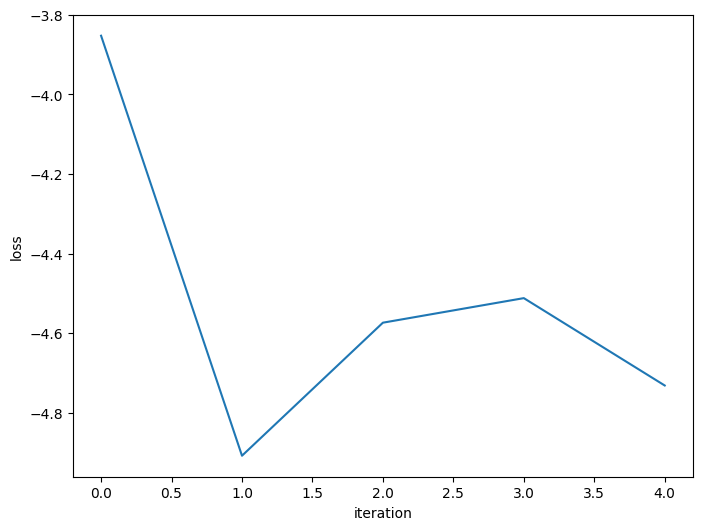

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -954.07208  validloss -908.61611±0.00000  bestvalidloss -908.61611  last_update 0
train: iter 1  trainloss -973.88912  validloss -930.35543±0.00000  bestvalidloss -930.35543  last_update 0
train: iter 2  trainloss -964.31039  validloss -946.15382±0.00000  bestvalidloss -946.15382  last_update 0
train: iter 3  trainloss -969.83574  validloss -945.68633±0.00000  bestvalidloss -946.15382  last_update 1
train: iter 4  trainloss -878.34996  validloss -932.16902±0.00000  bestvalidloss -946.15382  last_update 2
train: iter 5  trainloss -952.69204  validloss -743.29184±0.00000  bestvalidloss -946.15382  last_update 3
train: iter 6  trainloss -984.13372  validloss -907.18221±0.00000  bestvalidloss -946.15382  last_update 4
train: iter 7  trainloss -982.26505  validloss -951.30124±0.00000  bestvalidloss -951.30124  last_update 0
train: iter 8  trainloss -946.15963  validloss -814.25853±0.00000  bestvalidloss -951.30124  last_u

train: iter 75  trainloss -992.47506  validloss -984.86026±0.00000  bestvalidloss -1028.25013  last_update 41
train: iter 76  trainloss -965.86822  validloss -1006.60876±0.00000  bestvalidloss -1028.25013  last_update 42
train: iter 77  trainloss -992.94151  validloss -993.02435±0.00000  bestvalidloss -1028.25013  last_update 43
train: iter 78  trainloss -959.39259  validloss -799.59732±0.00000  bestvalidloss -1028.25013  last_update 44
train: iter 79  trainloss -967.88493  validloss -956.81182±0.00000  bestvalidloss -1028.25013  last_update 45
train: iter 80  trainloss -985.28646  validloss -983.47778±0.00000  bestvalidloss -1028.25013  last_update 46
train: iter 81  trainloss -905.40180  validloss -958.71186±0.00000  bestvalidloss -1028.25013  last_update 47
train: iter 82  trainloss -911.68608  validloss -759.48721±0.00000  bestvalidloss -1028.25013  last_update 48
train: iter 83  trainloss -977.70630  validloss -962.00352±0.00000  bestvalidloss -1028.25013  last_update 49
train: it

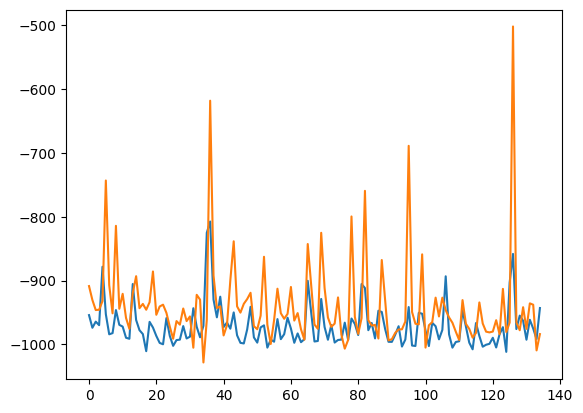

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-27 15:51:37.101274


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12
predict diverge [-48.35903978  31.33070664 -57.47410854 -33.702372  ] [ 0.14123591 15.29386744 -1.3833329  -5.35472023] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 160

 13

 14

 15

 16
predict diverge [-26.36128071  20.43617096 -48.32371281 -25.33161381] [-0.21601756 10.10559281 -1.13537972 -1.28732018] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 163

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27
predict diverge [-13.71826056 -18.66645352 -30.504832   -19.11481276] [ -0.54835361 -12.7998464   -0.87355702  -0.51932407] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.723446 99.99038  15.273924] sim_timestep 111

 28
predict diverge [ -7.74639417 -42.06593645 -34.94476147 -28.11856634] [ -0.18333129 -43.25117605  -0.77398284  -6.4095512 ] [ 94.9831    17.446892 199.98076   30.547848] [47.49155   8.72

In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.60908  validloss 0.73396±0.00000  bestvalidloss 0.73396  last_update 0
train: iter 1  trainloss 0.55374  validloss 0.63658±0.00000  bestvalidloss 0.63658  last_update 0
train: iter 2  trainloss 0.54066  validloss 0.62397±0.00000  bestvalidloss 0.62397  last_update 0
train: iter 3  trainloss 0.52948  validloss 0.62272±0.00000  bestvalidloss 0.62272  last_update 0
train: iter 4  trainloss 0.52352  validloss 0.60327±0.00000  bestvalidloss 0.60327  last_update 0
train: iter 5  trainloss 0.52135  validloss 0.59537±0.00000  bestvalidloss 0.59537  last_update 0
train: iter 6  trainloss 0.51522  validloss 0.58400±0.00000  bestvalidloss 0.58400  last_update 0
train: iter 7  trainloss 0.51178  validloss 0.60137±0.00000  bestvalidloss 0.58400  last_update 1
train: iter 8  trainloss 0.50388  validloss 0.59818±0.00000  bestvalidloss 0.58400  last_update 2
train: iter 9  trainloss 0.50477  validloss 0.58510±0.00000  bestvalidloss 0.58400  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.44044  validloss 0.59197±0.00000  bestvalidloss 0.54852  last_update 4
train: iter 84  trainloss 0.46188  validloss 0.59601±0.00000  bestvalidloss 0.54852  last_update 5
train: iter 85  trainloss 0.44642  validloss 0.57587±0.00000  bestvalidloss 0.54852  last_update 6
train: iter 86  trainloss 0.45246  validloss 0.56711±0.00000  bestvalidloss 0.54852  last_update 7
train: iter 87  trainloss 0.44373  validloss 0.56147±0.00000  bestvalidloss 0.54852  last_update 8
train: iter 88  trainloss 0.44372  validloss 0.58637±0.00000  bestvalidloss 0.54852  last_update 9
train: iter 89  trainloss 0.44308  validloss 0.56485±0.00000  bestvalidloss 0.54852  last_update 10
train: iter 90  trainloss 0.44096  validloss 0.59204±0.00000  bestvalidloss 0.54852  last_update 11
train: iter 91  trainloss 0.44230  validloss 0.57613±0.00000  bestvalidloss 0.54852  last_update 12
train: iter 92  trainloss 0.44042  validloss 0.56572±0.00000  bestvalidloss 0.54852  last_update 13
train:

train: iter 165  trainloss 0.42493  validloss 0.55290±0.00000  bestvalidloss 0.54852  last_update 86
train: iter 166  trainloss 0.42241  validloss 0.57040±0.00000  bestvalidloss 0.54852  last_update 87
train: iter 167  trainloss 0.42452  validloss 0.55508±0.00000  bestvalidloss 0.54852  last_update 88
train: iter 168  trainloss 0.42786  validloss 0.60540±0.00000  bestvalidloss 0.54852  last_update 89
train: iter 169  trainloss 0.42533  validloss 0.56023±0.00000  bestvalidloss 0.54852  last_update 90
train: iter 170  trainloss 0.42642  validloss 0.57155±0.00000  bestvalidloss 0.54852  last_update 91
train: iter 171  trainloss 0.42593  validloss 0.57827±0.00000  bestvalidloss 0.54852  last_update 92
train: iter 172  trainloss 0.42159  validloss 0.56450±0.00000  bestvalidloss 0.54852  last_update 93
train: iter 173  trainloss 0.43035  validloss 0.58346±0.00000  bestvalidloss 0.54852  last_update 94
train: iter 174  trainloss 0.42215  validloss 0.57134±0.00000  bestvalidloss 0.54852  last_

([0.6090786240063608,
  0.55374328577891,
  0.5406555507332087,
  0.529475512355566,
  0.5235153011977672,
  0.5213510169647634,
  0.5152150957845152,
  0.511784721724689,
  0.5038827762007714,
  0.5047736891545356,
  0.4956112057901919,
  0.5001949349418282,
  0.5006534991785884,
  0.49658490270376204,
  0.4967101589776576,
  0.4890095584094524,
  0.49406826589256525,
  0.4930467950180173,
  0.4910842283628881,
  0.4924091808497906,
  0.48877068599686024,
  0.48726782109588385,
  0.4841329036280513,
  0.4788688212633133,
  0.4870158225297928,
  0.4782581257633865,
  0.4930589088238776,
  0.4764576183632016,
  0.47596979402005674,
  0.47677835216745734,
  0.47487830817699433,
  0.46973062949255107,
  0.470127958804369,
  0.4682781921699643,
  0.4765579393133521,
  0.46911765383556486,
  0.47024494102224706,
  0.46690131155773995,
  0.4681447117589414,
  0.46817926643416286,
  0.46392294131219386,
  0.4619832843542099,
  0.4591759299859405,
  0.4650755200535059,
  0.46656104335561394,
 

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.465608512493968
valid_loss:  -7.8449763804435735
weight_alpha 1.0 h_min_tilde -11.383531 ell_tilde -5.941482086083889 kappa_tilde 0.00042866575951946794
train_loss:  -4.727326666808129
valid_loss:  -5.025222317647933
weight_alpha 0.1 h_min_tilde -11.383531 ell_tilde -4.7869057969760895 kappa_tilde 0.0003893490395978944


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 41.51970  validloss 45.50908±0.00000  bestvalidloss 45.50908  last_update 0
train: iter 1  trainloss 34.83903  validloss 37.05690±0.00000  bestvalidloss 37.05690  last_update 0
train: iter 2  trainloss 29.30789  validloss 30.77669±0.00000  bestvalidloss 30.77669  last_update 0
train: iter 3  trainloss 24.56031  validloss 25.86721±0.00000  bestvalidloss 25.86721  last_update 0
train: iter 4  trainloss 21.01869  validloss 21.78406±0.00000  bestvalidloss 21.78406  last_update 0
train: iter 5  trainloss 18.02031  validloss 18.54037±0.00000  bestvalidloss 18.54037  last_update 0
train: iter 6  trainloss 15.36102  validloss 15.96513±0.00000  bestvalidloss 15.96513  last_update 0
train: iter 7  trainloss 13.38993  validloss 13.50536±0.00000  bestvalidloss 13.50536  last_update 0
train: iter 8  trainloss 11.60402  validloss 11.78746±0.00000  bestvalidloss 11.78746  last_update 0
train: iter 9  trainloss 10.17967  validloss 10.15529±0.00000  bestvalidloss 10.15529  last

train: iter 83  trainloss 0.31121  validloss 0.19474±0.00000  bestvalidloss 0.11463  last_update 2
train: iter 84  trainloss 0.31946  validloss 0.15325±0.00000  bestvalidloss 0.11463  last_update 3
train: iter 85  trainloss 0.29763  validloss 0.25978±0.00000  bestvalidloss 0.11463  last_update 4
train: iter 86  trainloss 0.29459  validloss 0.19819±0.00000  bestvalidloss 0.11463  last_update 5
train: iter 87  trainloss 0.28501  validloss 0.15725±0.00000  bestvalidloss 0.11463  last_update 6
train: iter 88  trainloss 0.29932  validloss 0.30201±0.00000  bestvalidloss 0.11463  last_update 7
train: iter 89  trainloss 0.27168  validloss 0.25074±0.00000  bestvalidloss 0.11463  last_update 8
train: iter 90  trainloss 0.23579  validloss 0.17966±0.00000  bestvalidloss 0.11463  last_update 9
train: iter 91  trainloss 0.22093  validloss 0.25351±0.00000  bestvalidloss 0.11463  last_update 10
train: iter 92  trainloss 0.27108  validloss 0.24088±0.00000  bestvalidloss 0.11463  last_update 11
train: i

train: iter 167  trainloss 0.19597  validloss 0.24991±0.00000  bestvalidloss 0.08213  last_update 55
train: iter 168  trainloss 0.17803  validloss 0.26033±0.00000  bestvalidloss 0.08213  last_update 56
train: iter 169  trainloss 0.15458  validloss 0.56906±0.00000  bestvalidloss 0.08213  last_update 57
train: iter 170  trainloss 0.17186  validloss 0.37236±0.00000  bestvalidloss 0.08213  last_update 58
train: iter 171  trainloss 0.16469  validloss 0.40487±0.00000  bestvalidloss 0.08213  last_update 59
train: iter 172  trainloss 0.12282  validloss 0.49044±0.00000  bestvalidloss 0.08213  last_update 60
train: iter 173  trainloss 0.15698  validloss 0.43711±0.00000  bestvalidloss 0.08213  last_update 61
train: iter 174  trainloss 0.18242  validloss 0.30313±0.00000  bestvalidloss 0.08213  last_update 62
train: iter 175  trainloss 0.19799  validloss 0.43036±0.00000  bestvalidloss 0.08213  last_update 63
train: iter 176  trainloss 0.13536  validloss 0.24092±0.00000  bestvalidloss 0.08213  last_

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-2.4375, -0.1712, -4.3844, -0.7643], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 9.61657  validloss 11.26963±0.00000  bestvalidloss 11.26963  last_update 0
train: iter 1  trainloss 9.02902  validloss 10.79763±0.00000  bestvalidloss 10.79763  last_update 0
train: iter 2  trainloss 8.74015  validloss 9.56925±0.00000  bestvalidloss 9.56925  last_update 0
train: iter 3  trainloss 8.51675  validloss 9.84240±0.00000  bestvalidloss 9.56925  last_update 1
train: iter 4  trainloss 8.60033  validloss 9.69110±0.00000  bestvalidloss 9.56925  last_update 2
train: iter 5  trainloss 8.51874  validloss 9.54601±0.00000  bestvalidloss 9.54601  last_update 0
train: iter 6  trainloss 8.41460  validloss 9.66065±0.00000  bestvalidloss 9.54601  last_update 1
train: iter 7  trainloss 8.48412  validloss 9.75912±0.00000  bestvalidloss 9.54601  last_update 2
train: iter 8  trainloss 8.39033  validloss 9.43825±0.00000  bestvalidloss 9.43825  last_update 0
train: iter 9  trainloss 8.36179  validloss 9.32213±0.00000  bestvalidloss 9.32213  last_update 0
train: iter 10  

train: iter 83  trainloss 7.96465  validloss 9.32702±0.00000  bestvalidloss 9.00342  last_update 54
train: iter 84  trainloss 7.86210  validloss 9.53742±0.00000  bestvalidloss 9.00342  last_update 55
train: iter 85  trainloss 7.85263  validloss 9.57734±0.00000  bestvalidloss 9.00342  last_update 56
train: iter 86  trainloss 7.83993  validloss 9.80372±0.00000  bestvalidloss 9.00342  last_update 57
train: iter 87  trainloss 7.79527  validloss 9.69683±0.00000  bestvalidloss 9.00342  last_update 58
train: iter 88  trainloss 7.79368  validloss 9.69757±0.00000  bestvalidloss 9.00342  last_update 59
train: iter 89  trainloss 7.83063  validloss 9.82174±0.00000  bestvalidloss 9.00342  last_update 60
train: iter 90  trainloss 7.81011  validloss 10.12524±0.00000  bestvalidloss 9.00342  last_update 61
train: iter 91  trainloss 7.77400  validloss 9.55735±0.00000  bestvalidloss 9.00342  last_update 62
train: iter 92  trainloss 8.02108  validloss 10.02300±0.00000  bestvalidloss 9.00342  last_update 6

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-7.7574)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(17.6425)


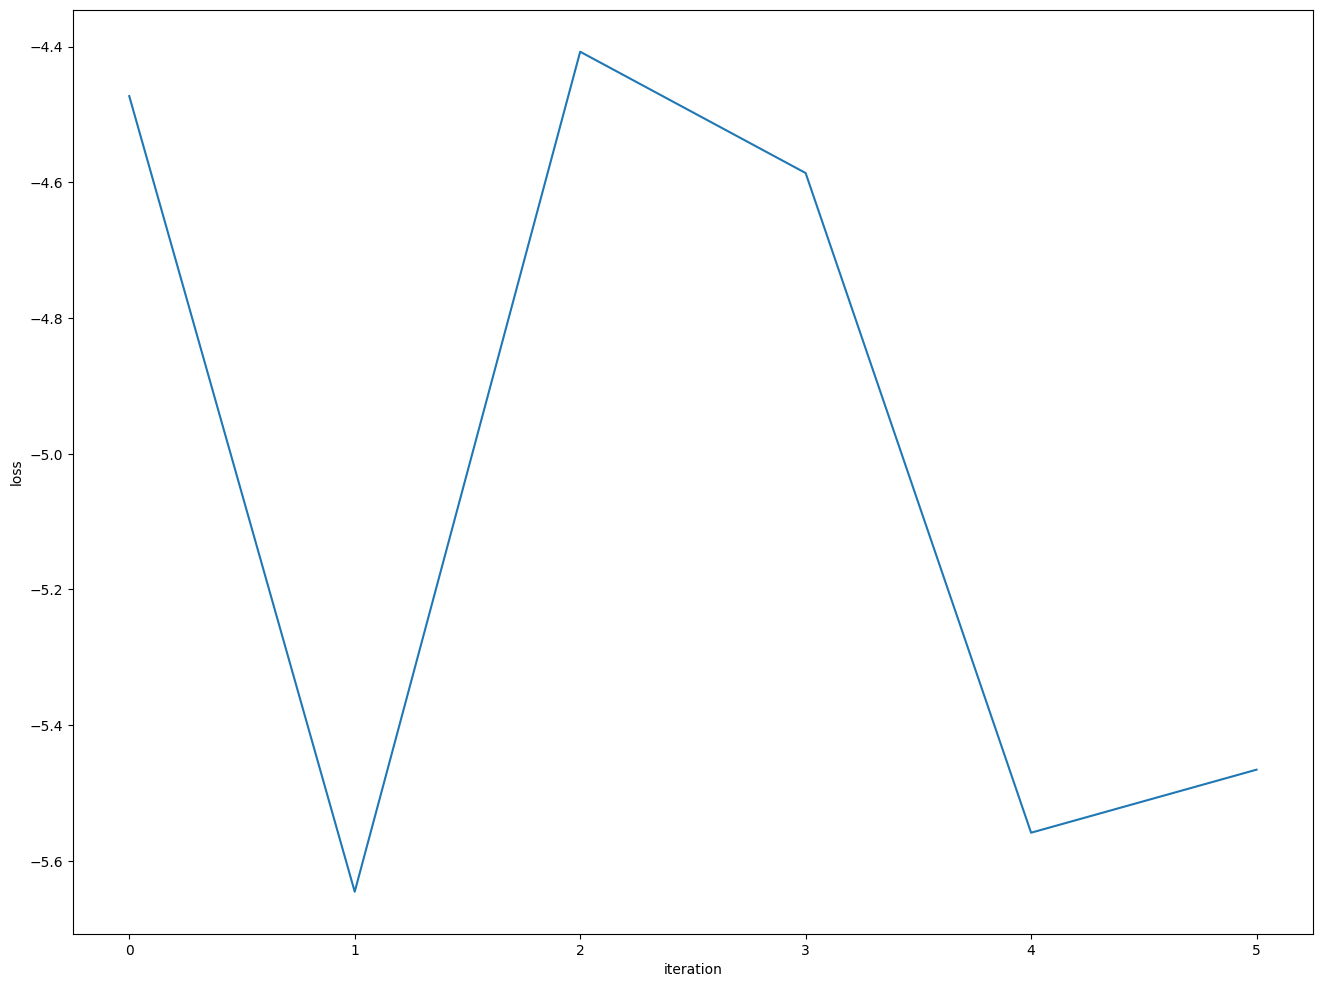

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

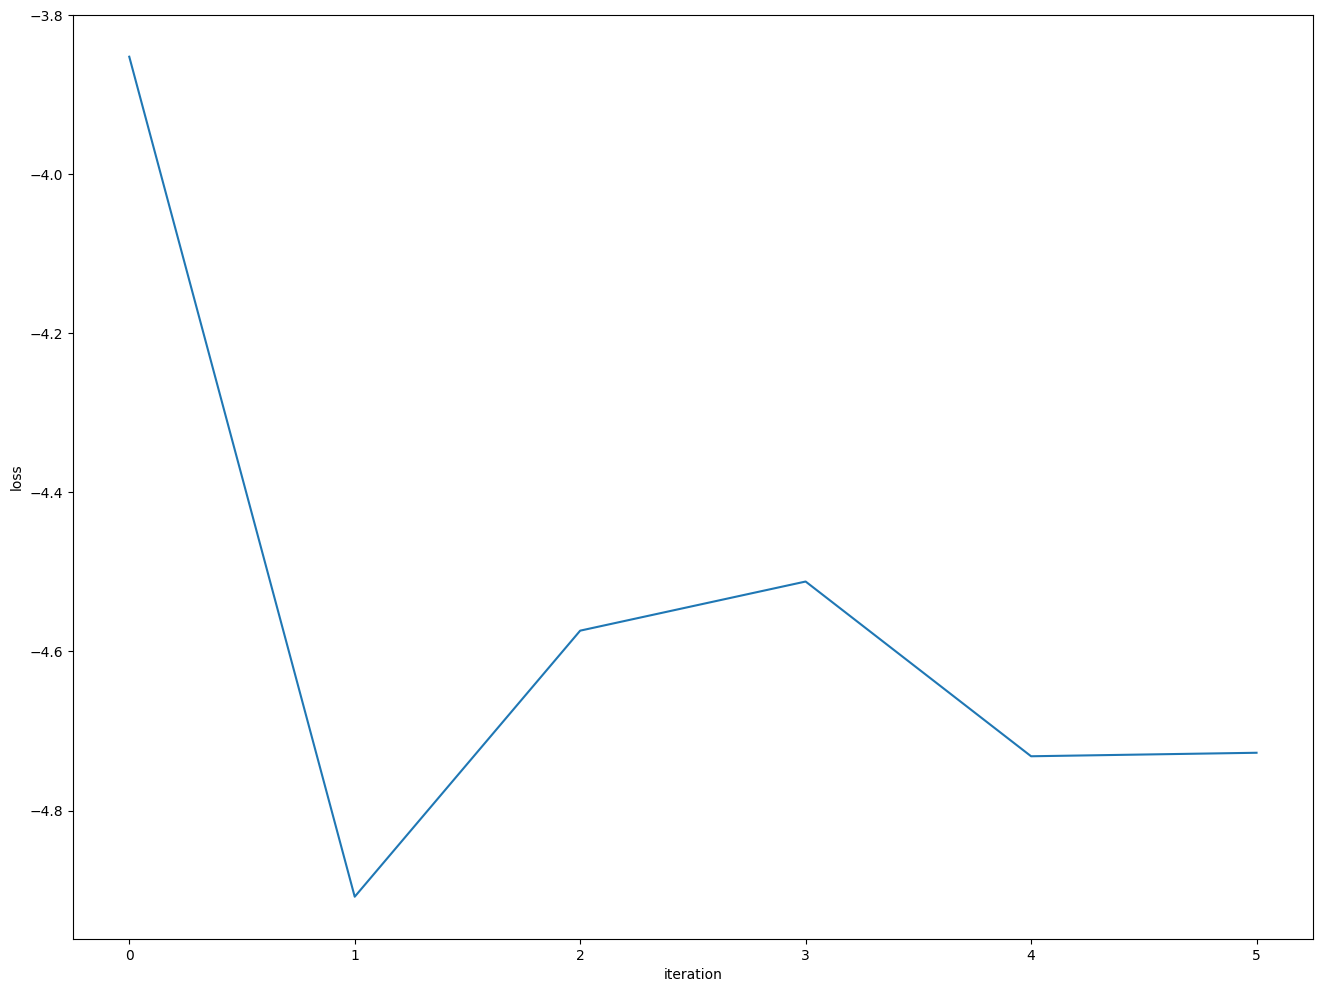

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")